In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = PerceptualLoss()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [15]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [16]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [17]:
from codes.activation import Activation
import torchvision.models as models

In [18]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.densenet161()
        encoder.features[0] = nn.Conv2d(in_channel, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.classifier = nn.Linear(in_features=2208, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [19]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [20]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [21]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [22]:
len(trainset), len(testset)

(1344, 191)

In [23]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fed7d60bf40>,)

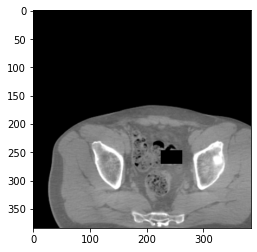

In [24]:
plt.imshow(x.squeeze(), 'gray'),

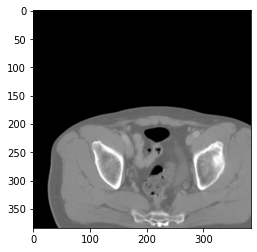

In [25]:
plt.imshow(y.squeeze(), 'gray')

In [26]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [27]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [28]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [29]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [30]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [31]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [32]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [33]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [34]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [08:17,  1.48s/it]
336it [00:47,  7.13it/s]
48it [00:06,  6.91it/s]
336it [08:16,  1.48s/it]
336it [00:47,  7.14it/s]
48it [00:06,  6.92it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.13it/s]
48it [00:06,  6.93it/s]
336it [08:15,  1.48s/it]
336it [00:47,  7.14it/s]
48it [00:06,  6.91it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.11it/s]
48it [00:06,  6.90it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.11it/s]
48it [00:06,  6.90it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.14it/s]
48it [00:06,  6.91it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.12it/s]
48it [00:06,  6.91it/s]
336it [08:16,  1.48s/it]
336it [00:47,  7.11it/s]
48it [00:06,  6.91it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.13it/s]
48it [00:06,  6.87it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.12it/s]
48it [00:06,  6.91it/s]
336it [08:17,  1.48s/it]
336it [00:47,  7.12it/s]
48it [00:06,  6.86it/s]
74it [01:49,  1.47s/it]wandb: Network error resolved after 0:00:46.720592, resuming normal operation.
336it [08:

In [35]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [36]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [37]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9044584631919861
psnr score = 26.629247665405273
snr score = 16.69218635559082
mae error = 0.01590082421898842
air dice score = 0.995003037369447
bone dice score = 0.9474626865679483
contour dice score = 0.6312649250030518


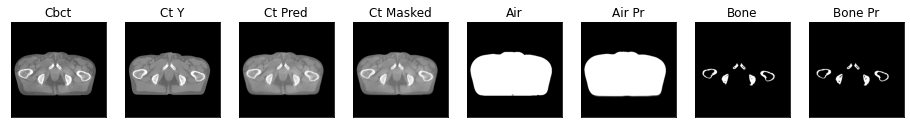

ssim score = 0.9047738909721375
psnr score = 26.431779861450195
snr score = 16.542253494262695
mae error = 0.016322433948516846
air dice score = 0.9950657894736891
bone dice score = 0.9421091997016887
contour dice score = 0.576900064945221


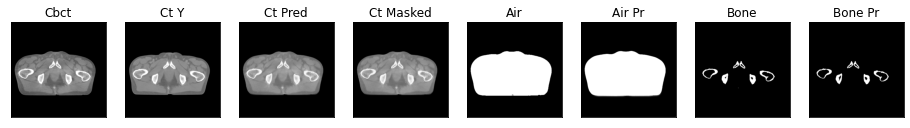

ssim score = 0.9033305644989014
psnr score = 26.062416076660156
snr score = 16.335784912109375
mae error = 0.01803690940141678
air dice score = 0.9956302784472835
bone dice score = 0.9236465781419351
contour dice score = 0.6407185792922974


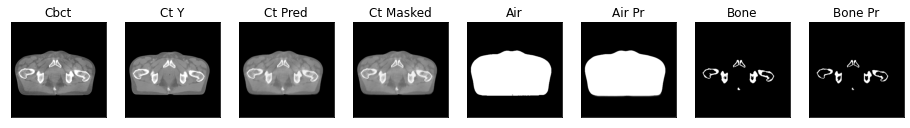

ssim score = 0.9013081192970276
psnr score = 25.892276763916016
snr score = 16.254899978637695
mae error = 0.01902695745229721
air dice score = 0.9947778628501927
bone dice score = 0.9010294805814104
contour dice score = 0.6822822690010071


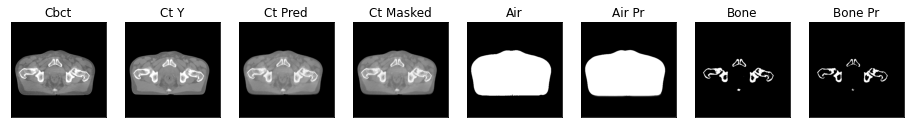

1it [00:01,  1.65s/it]

ssim score = 0.9002622961997986
psnr score = 25.877988815307617
snr score = 16.280912399291992
mae error = 0.019390229135751724
air dice score = 0.9943384894105193
bone dice score = 0.8717283149483913
contour dice score = 0.7035477757453918


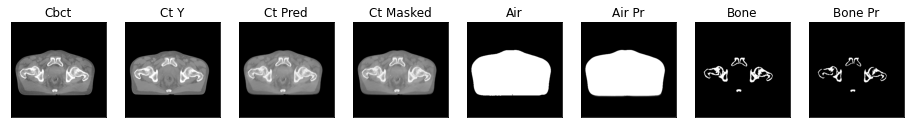

ssim score = 0.8948115706443787
psnr score = 25.40473747253418
snr score = 15.944195747375488
mae error = 0.021609671413898468
air dice score = 0.9943135180039021
bone dice score = 0.8321611860878905
contour dice score = 0.7466827630996704


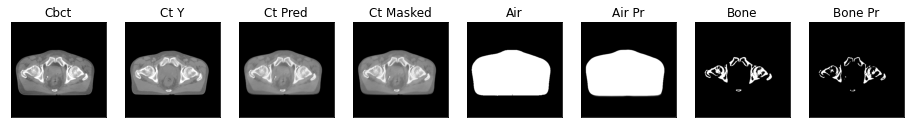

ssim score = 0.8924370408058167
psnr score = 25.128318786621094
snr score = 15.643721580505371
mae error = 0.02186042256653309
air dice score = 0.9946048178379508
bone dice score = 0.8159719012864778
contour dice score = 0.7562008500099182


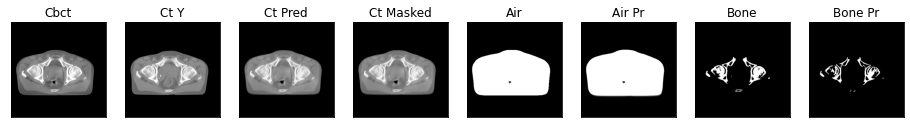

ssim score = 0.8926445841789246
psnr score = 25.822242736816406
snr score = 16.152109146118164
mae error = 0.019633229821920395
air dice score = 0.9942669614895953
bone dice score = 0.8717948717961217
contour dice score = 0.7451456189155579


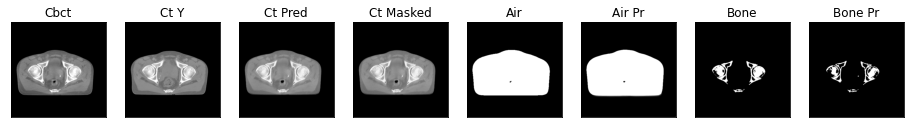

2it [00:02,  1.51s/it]

ssim score = 0.8943121433258057
psnr score = 26.3833065032959
snr score = 16.618616104125977
mae error = 0.018395928665995598
air dice score = 0.9943277818006333
bone dice score = 0.9183673469396085
contour dice score = 0.7527405619621277


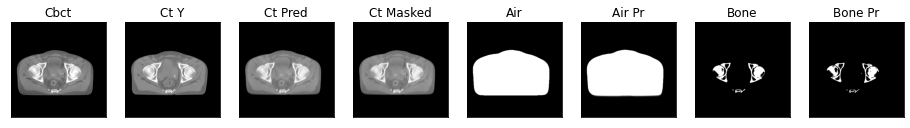

ssim score = 0.895451545715332
psnr score = 26.097524642944336
snr score = 16.317550659179688
mae error = 0.01874789223074913
air dice score = 0.9946122217496155
bone dice score = 0.909967845660129
contour dice score = 0.6768478751182556


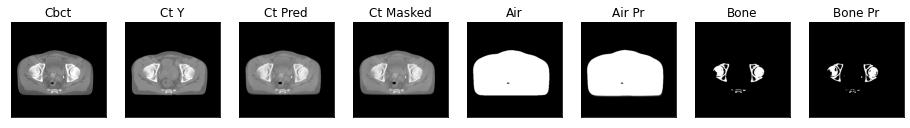

ssim score = 0.8991954922676086
psnr score = 26.205045700073242
snr score = 16.45734214782715
mae error = 0.018870949745178223
air dice score = 0.9938644064347482
bone dice score = 0.9365538735536894
contour dice score = 0.7000610828399658


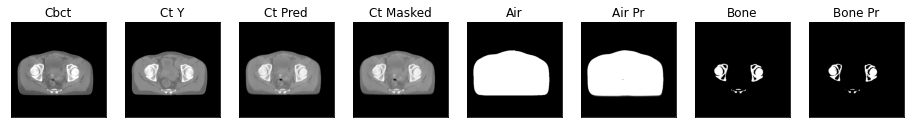

ssim score = 0.8984852433204651
psnr score = 25.284605026245117
snr score = 15.560611724853516
mae error = 0.020107362419366837
air dice score = 0.993919565418692
bone dice score = 0.9265434880585113
contour dice score = 0.6756426095962524


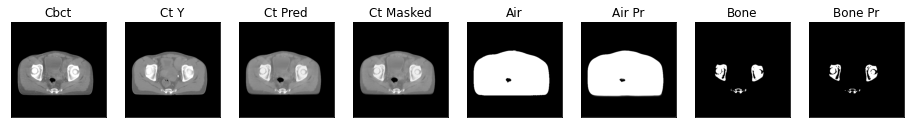

3it [00:04,  1.41s/it]

ssim score = 0.9005264043807983
psnr score = 24.618642807006836
snr score = 14.862727165222168
mae error = 0.02071436680853367
air dice score = 0.9929523294734071
bone dice score = 0.9463460855152629
contour dice score = 0.6458333134651184


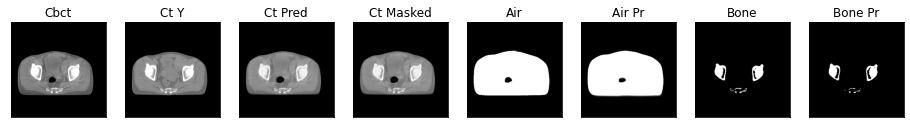

ssim score = 0.8978643417358398
psnr score = 24.65715217590332
snr score = 14.759279251098633
mae error = 0.01908157207071781
air dice score = 0.9929671205022661
bone dice score = 0.9208670671203857
contour dice score = 0.6567901372909546


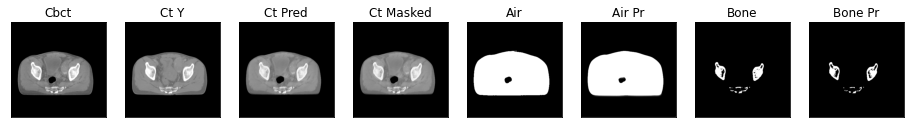

ssim score = 0.8940829038619995
psnr score = 24.463768005371094
snr score = 14.480237007141113
mae error = 0.01912412792444229
air dice score = 0.99253558249869
bone dice score = 0.914317302378188
contour dice score = 0.7333333492279053


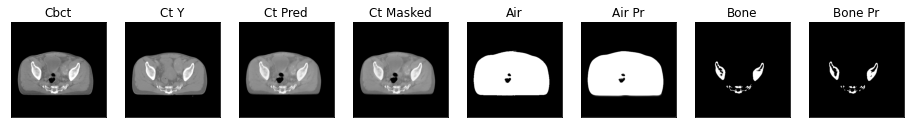

ssim score = 0.8860025405883789
psnr score = 24.09176254272461
snr score = 14.131712913513184
mae error = 0.020667409524321556
air dice score = 0.9918897429101596
bone dice score = 0.9152722443570349
contour dice score = 0.7984980940818787


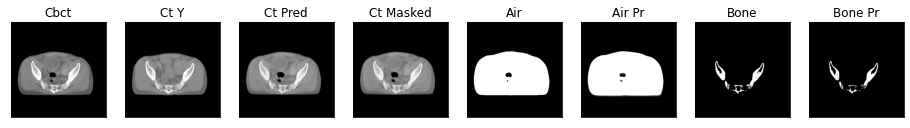

4it [00:05,  1.40s/it]

ssim score = 0.8837350606918335
psnr score = 23.338634490966797
snr score = 13.376041412353516
mae error = 0.022341981530189514
air dice score = 0.9916692577383786
bone dice score = 0.9061390157292474
contour dice score = 0.7851758599281311


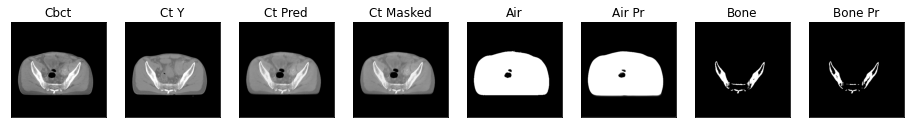

ssim score = 0.8755190372467041
psnr score = 22.718809127807617
snr score = 12.65445613861084
mae error = 0.023300182074308395
air dice score = 0.9916436351812804
bone dice score = 0.8896373057009115
contour dice score = 0.7017979025840759


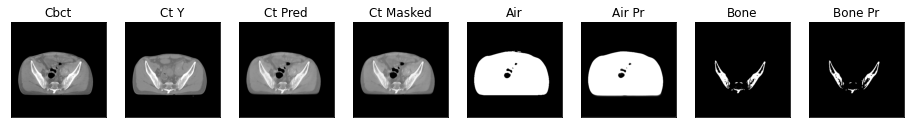

ssim score = 0.8734505772590637
psnr score = 22.411983489990234
snr score = 12.296947479248047
mae error = 0.02399131841957569
air dice score = 0.9908150672214859
bone dice score = 0.8842213114768926
contour dice score = 0.7270408272743225


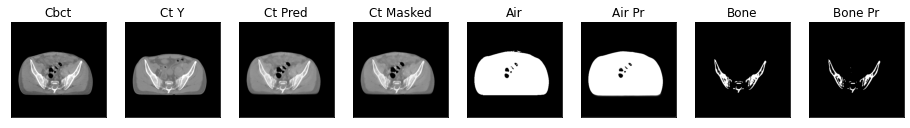

ssim score = 0.8776086568832397
psnr score = 22.51382064819336
snr score = 12.386475563049316
mae error = 0.024036908522248268
air dice score = 0.9915604395604488
bone dice score = 0.881774707759275
contour dice score = 0.6417247653007507


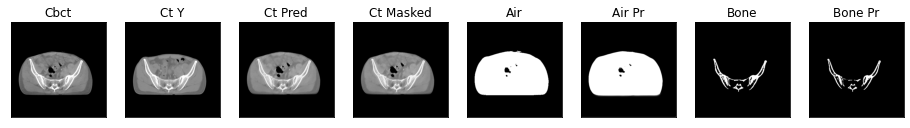

5it [00:06,  1.33s/it]

ssim score = 0.8756828904151917
psnr score = 22.595613479614258
snr score = 12.403422355651855
mae error = 0.023557789623737335
air dice score = 0.9921752044865203
bone dice score = 0.8793550244762546
contour dice score = 0.606914222240448


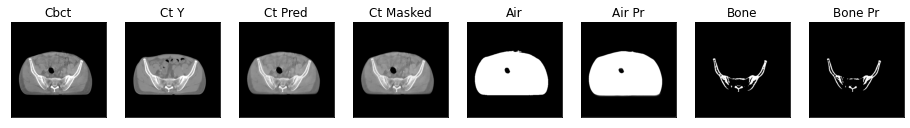

ssim score = 0.8737195134162903
psnr score = 22.491191864013672
snr score = 12.239570617675781
mae error = 0.02333122491836548
air dice score = 0.9914705488322338
bone dice score = 0.8914510686179492
contour dice score = 0.5338491201400757


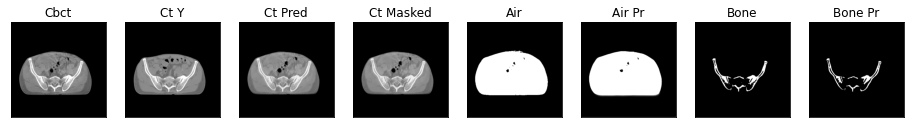

ssim score = 0.8801286816596985
psnr score = 22.767114639282227
snr score = 12.482067108154297
mae error = 0.022801360115408897
air dice score = 0.9905899588662979
bone dice score = 0.8935270805826483
contour dice score = 0.6251621246337891


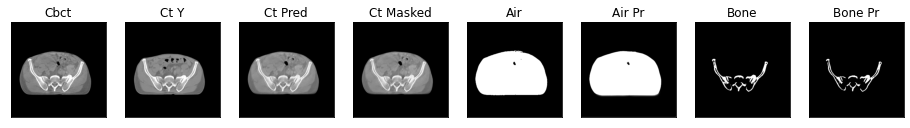

ssim score = 0.8800621628761292
psnr score = 22.829647064208984
snr score = 12.496033668518066
mae error = 0.02277226559817791
air dice score = 0.9904480327496129
bone dice score = 0.882171340366836
contour dice score = 0.6432825922966003


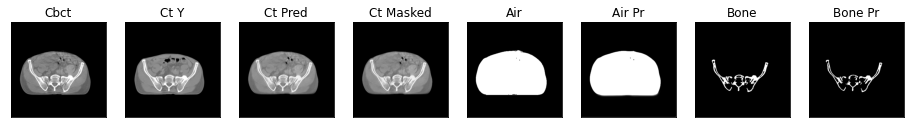

6it [00:07,  1.28s/it]

ssim score = 0.8778159022331238
psnr score = 22.68194007873535
snr score = 12.251328468322754
mae error = 0.022978944703936577
air dice score = 0.9900542808081155
bone dice score = 0.8829117828515372
contour dice score = 0.554362416267395


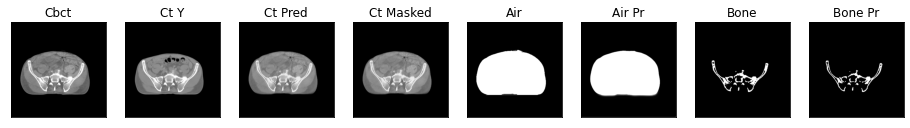

ssim score = 0.8804414868354797
psnr score = 22.76042938232422
snr score = 12.247081756591797
mae error = 0.022668423131108284
air dice score = 0.9899080405564844
bone dice score = 0.8760147601491265
contour dice score = 0.6485384106636047


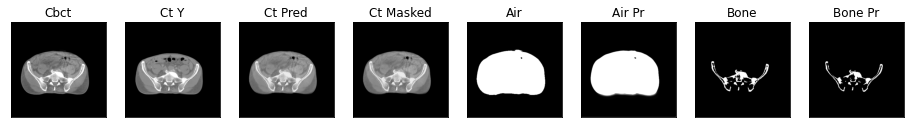

ssim score = 0.8763090372085571
psnr score = 22.82219696044922
snr score = 12.217662811279297
mae error = 0.02279784344136715
air dice score = 0.9890398419810317
bone dice score = 0.884652278178841
contour dice score = 0.6345885396003723


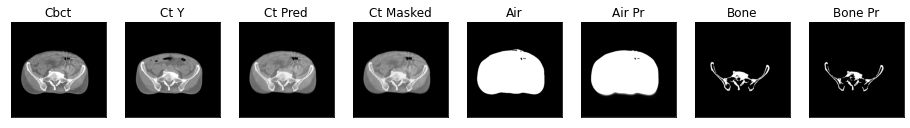

ssim score = 0.8760616183280945
psnr score = 22.805801391601562
snr score = 12.160161972045898
mae error = 0.022599438205361366
air dice score = 0.9865108791101735
bone dice score = 0.8927437641735516
contour dice score = 0.5811001658439636


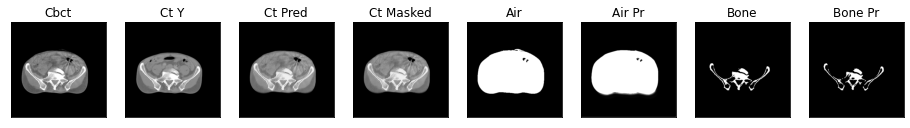

7it [00:09,  1.31s/it]

ssim score = 0.8640497326850891
psnr score = 23.59562873840332
snr score = 14.967785835266113
mae error = 0.023778874427080154
air dice score = 0.9958971689226065
bone dice score = 0.9608801956002176
contour dice score = 0.33347511291503906


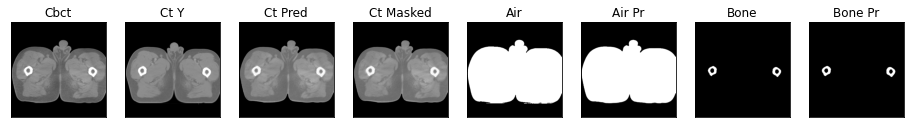

ssim score = 0.8706538677215576
psnr score = 24.18073272705078
snr score = 15.592145919799805
mae error = 0.022388363257050514
air dice score = 0.9953665347203072
bone dice score = 0.9642141425718805
contour dice score = 0.3125


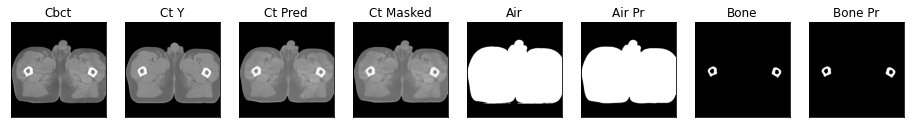

ssim score = 0.8784900903701782
psnr score = 24.904857635498047
snr score = 16.40372085571289
mae error = 0.021700972691178322
air dice score = 0.9954470930268021
bone dice score = 0.9726526891528566
contour dice score = 0.30311110615730286


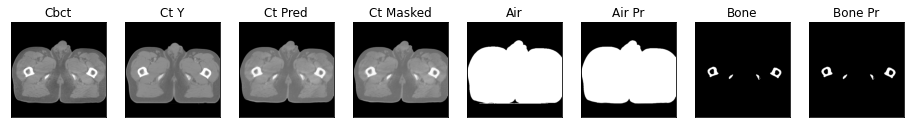

ssim score = 0.8845279216766357
psnr score = 25.250045776367188
snr score = 16.911466598510742
mae error = 0.02298458106815815
air dice score = 0.996352443620414
bone dice score = 0.9782297791200028
contour dice score = 0.3241252303123474


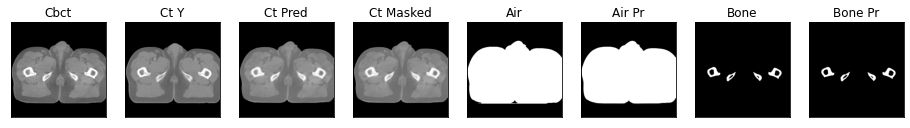

8it [00:10,  1.27s/it]

ssim score = 0.8850334882736206
psnr score = 25.319236755371094
snr score = 17.108800888061523
mae error = 0.024073060601949692
air dice score = 0.9962900180371503
bone dice score = 0.970178372352701
contour dice score = 0.28093022108078003


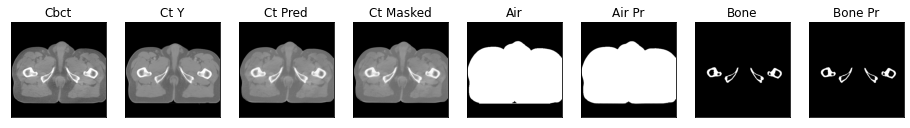

ssim score = 0.8857054710388184
psnr score = 25.515377044677734
snr score = 17.408178329467773
mae error = 0.024955466389656067
air dice score = 0.9968342834487708
bone dice score = 0.958255914778171
contour dice score = 0.302238792181015


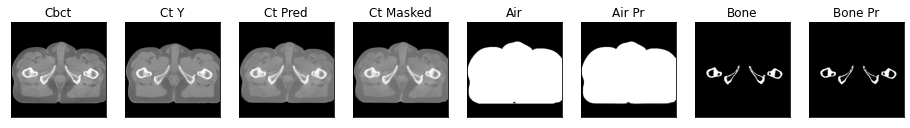

ssim score = 0.8852874636650085
psnr score = 25.610736846923828
snr score = 17.570642471313477
mae error = 0.02596423774957657
air dice score = 0.9965828640506547
bone dice score = 0.9379342288103527
contour dice score = 0.2673497796058655


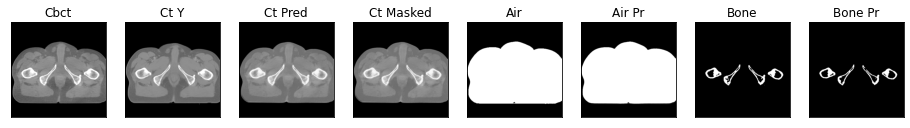

ssim score = 0.8839699625968933
psnr score = 25.71730613708496
snr score = 17.667320251464844
mae error = 0.02552831918001175
air dice score = 0.9969157345264746
bone dice score = 0.944959128065995
contour dice score = 0.2850510776042938


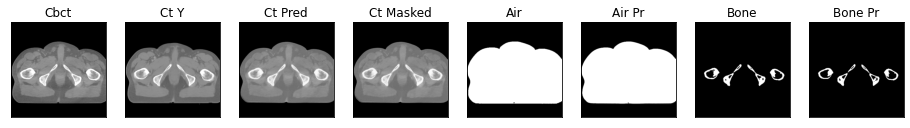

9it [00:11,  1.24s/it]

ssim score = 0.8870643973350525
psnr score = 25.87203598022461
snr score = 17.80838394165039
mae error = 0.025065530091524124
air dice score = 0.997125256673513
bone dice score = 0.9486489396065384
contour dice score = 0.2534818947315216


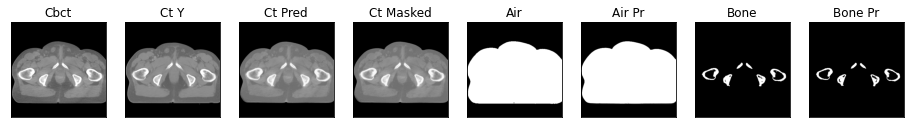

ssim score = 0.8892757296562195
psnr score = 26.08730125427246
snr score = 18.03565216064453
mae error = 0.025021633133292198
air dice score = 0.997122336377475
bone dice score = 0.9416475972546722
contour dice score = 0.2715016305446625


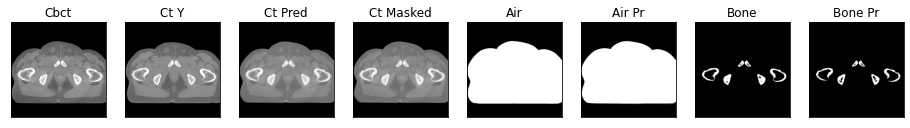

ssim score = 0.8907451629638672
psnr score = 26.0178279876709
snr score = 18.00526237487793
mae error = 0.025421693921089172
air dice score = 0.9971355899971491
bone dice score = 0.9439756211914676
contour dice score = 0.2734484374523163


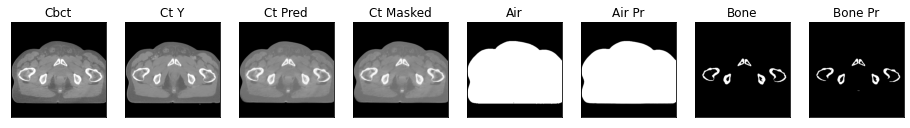

ssim score = 0.889106035232544
psnr score = 25.491249084472656
snr score = 17.619972229003906
mae error = 0.02819107659161091
air dice score = 0.9972839491498242
bone dice score = 0.9190798932027204
contour dice score = 0.25549834966659546


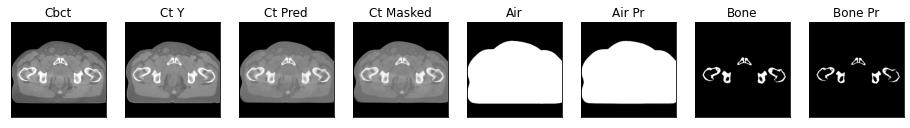

10it [00:12,  1.28s/it]

ssim score = 0.8887312412261963
psnr score = 25.146526336669922
snr score = 17.369935989379883
mae error = 0.030520617961883545
air dice score = 0.9974836556593968
bone dice score = 0.8756069568299143
contour dice score = 0.2401500940322876


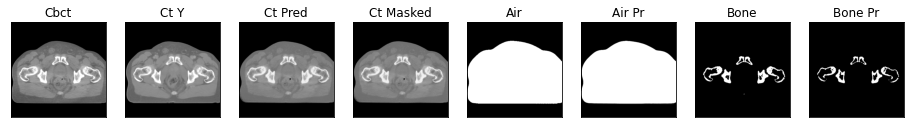

ssim score = 0.8763149976730347
psnr score = 24.23433494567871
snr score = 16.4237003326416
mae error = 0.03151791915297508
air dice score = 0.9963911427649604
bone dice score = 0.8241286863286494
contour dice score = 0.2612781822681427


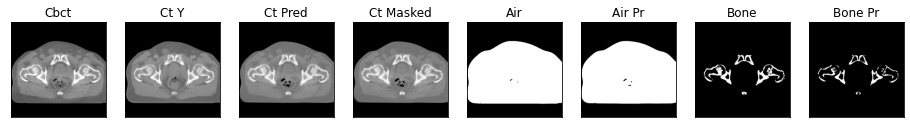

ssim score = 0.8714157342910767
psnr score = 23.21721649169922
snr score = 15.478763580322266
mae error = 0.03431554511189461
air dice score = 0.995802715606925
bone dice score = 0.7476198160420557
contour dice score = 0.2606232166290283


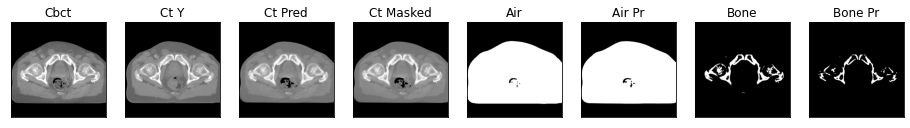

ssim score = 0.8738808035850525
psnr score = 23.910114288330078
snr score = 16.03557014465332
mae error = 0.03138234093785286
air dice score = 0.9963686813849703
bone dice score = 0.801400700352162
contour dice score = 0.28017038106918335


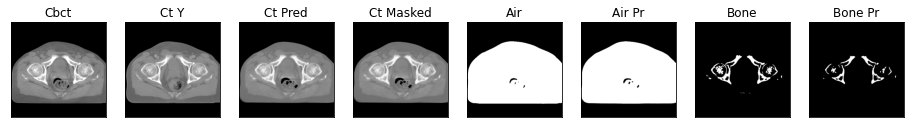

11it [00:13,  1.25s/it]

ssim score = 0.8809995651245117
psnr score = 24.69800567626953
snr score = 16.644895553588867
mae error = 0.027676288038492203
air dice score = 0.9969227420846778
bone dice score = 0.8437975233560308
contour dice score = 0.31134313344955444


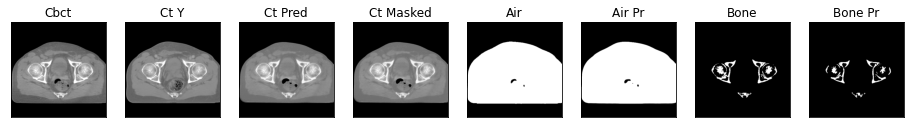

ssim score = 0.8812428712844849
psnr score = 25.23331069946289
snr score = 17.089616775512695
mae error = 0.02603410929441452
air dice score = 0.9977491377745521
bone dice score = 0.8643578643594954
contour dice score = 0.3241181969642639


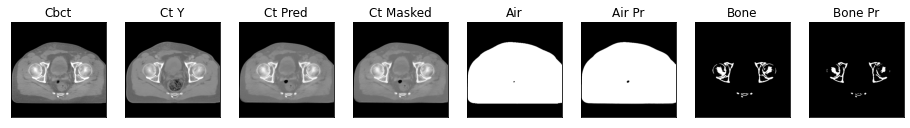

ssim score = 0.8821300864219666
psnr score = 25.265504837036133
snr score = 17.137500762939453
mae error = 0.026252495124936104
air dice score = 0.9982868598505569
bone dice score = 0.867286370255714
contour dice score = 0.3381088972091675


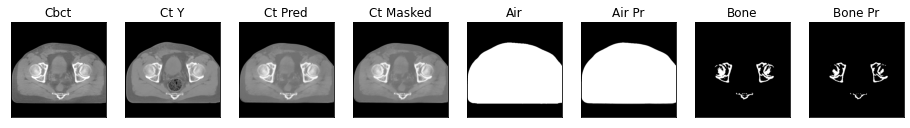

ssim score = 0.8691987991333008
psnr score = 24.8992919921875
snr score = 16.781322479248047
mae error = 0.027625419199466705
air dice score = 0.9980578254974544
bone dice score = 0.858049329650414
contour dice score = 0.3320574164390564


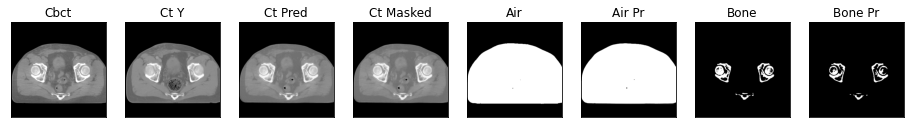

12it [00:15,  1.23s/it]

ssim score = 0.8759820461273193
psnr score = 24.919004440307617
snr score = 16.862625122070312
mae error = 0.028171785175800323
air dice score = 0.9980329315447933
bone dice score = 0.8728813559334561
contour dice score = 0.3688485324382782


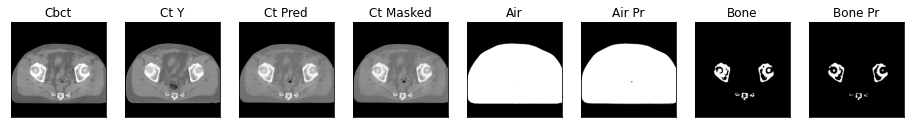

ssim score = 0.8760274648666382
psnr score = 24.929882049560547
snr score = 16.94358253479004
mae error = 0.029454516246914864
air dice score = 0.9978074350675287
bone dice score = 0.9168601950774096
contour dice score = 0.3314231038093567


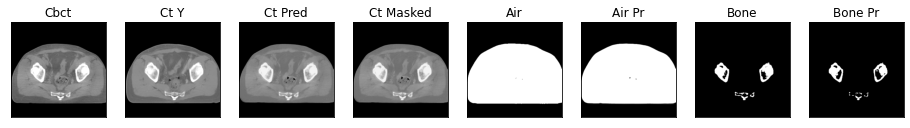

ssim score = 0.8855454325675964
psnr score = 25.34314727783203
snr score = 17.237743377685547
mae error = 0.026973003521561623
air dice score = 0.9977581367352343
bone dice score = 0.9012088370164526
contour dice score = 0.30071598291397095


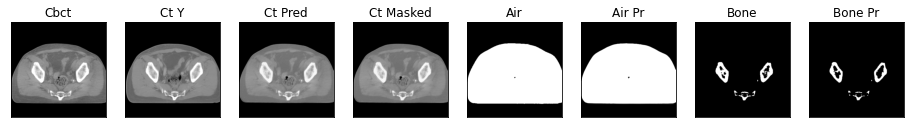

ssim score = 0.8783985376358032
psnr score = 24.40569305419922
snr score = 16.381916046142578
mae error = 0.029726648703217506
air dice score = 0.9969783324325671
bone dice score = 0.8966712266311293
contour dice score = 0.2781774699687958


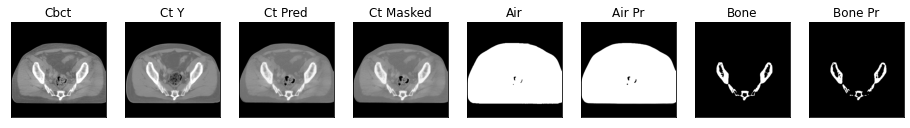

13it [00:16,  1.27s/it]

ssim score = 0.8770362734794617
psnr score = 24.16599464416504
snr score = 16.222368240356445
mae error = 0.031629856675863266
air dice score = 0.9959276795132866
bone dice score = 0.8521339044910984
contour dice score = 0.22928708791732788


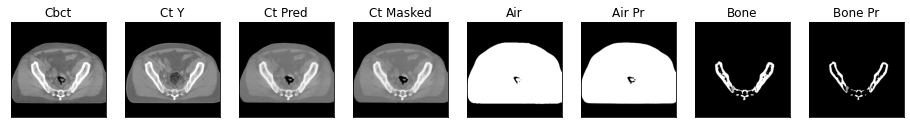

ssim score = 0.8609748482704163
psnr score = 23.859664916992188
snr score = 15.937593460083008
mae error = 0.032411303371191025
air dice score = 0.9964466353122517
bone dice score = 0.8350423899892205
contour dice score = 0.19333010911941528


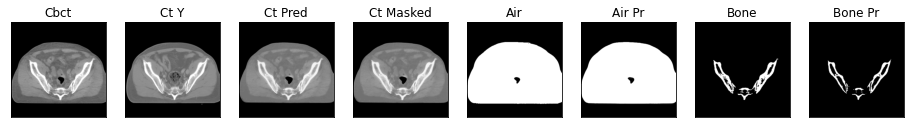

ssim score = 0.8627951145172119
psnr score = 24.409208297729492
snr score = 16.49967384338379
mae error = 0.03155459091067314
air dice score = 0.996342107019153
bone dice score = 0.8494614948591023
contour dice score = 0.17084942758083344


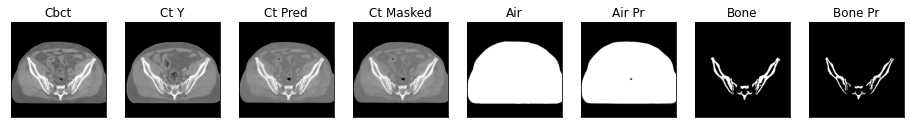

ssim score = 0.8065950870513916
psnr score = 21.362817764282227
snr score = 11.243027687072754
mae error = 0.032205529510974884
air dice score = 0.9941142999395479
bone dice score = 0.9392293767794355
contour dice score = 0.6400886178016663


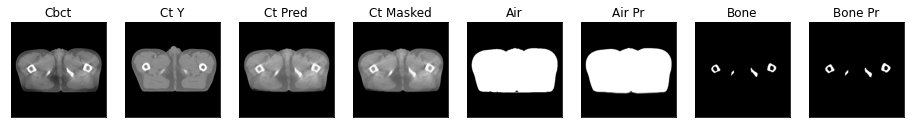

14it [00:17,  1.25s/it]

ssim score = 0.7982928156852722
psnr score = 21.070140838623047
snr score = 11.163330078125
mae error = 0.033571209758520126
air dice score = 0.9942447951200157
bone dice score = 0.9309210526329992
contour dice score = 0.6439185738563538


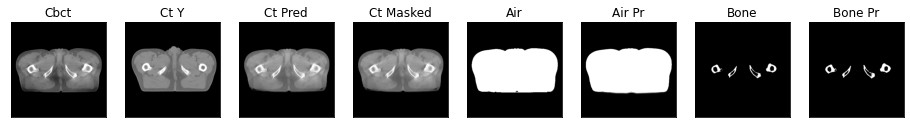

ssim score = 0.795985221862793
psnr score = 21.078907012939453
snr score = 11.303234100341797
mae error = 0.03374424949288368
air dice score = 0.9946157094594642
bone dice score = 0.9131274131290902
contour dice score = 0.6468647122383118


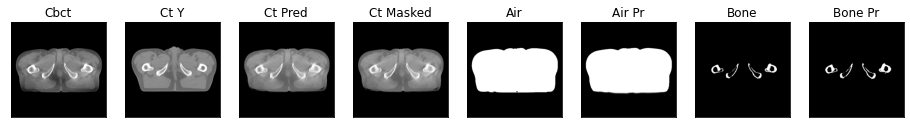

ssim score = 0.7962808012962341
psnr score = 21.277679443359375
snr score = 11.572409629821777
mae error = 0.033077795058488846
air dice score = 0.9944093999072656
bone dice score = 0.9118086696578511
contour dice score = 0.5894621014595032


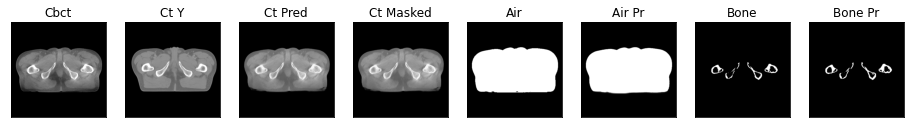

ssim score = 0.7929732799530029
psnr score = 21.238239288330078
snr score = 11.580533981323242
mae error = 0.033282238990068436
air dice score = 0.9943041563086098
bone dice score = 0.9171171171186105
contour dice score = 0.5956284403800964


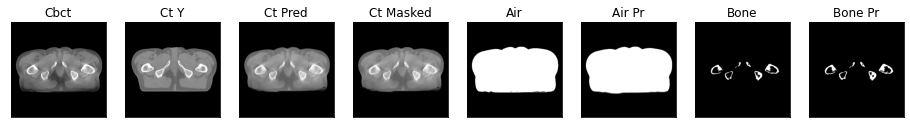

15it [00:18,  1.22s/it]

ssim score = 0.7909315824508667
psnr score = 21.35301971435547
snr score = 11.700933456420898
mae error = 0.0328030027449131
air dice score = 0.994409910888942
bone dice score = 0.9283058948499149
contour dice score = 0.5811601877212524


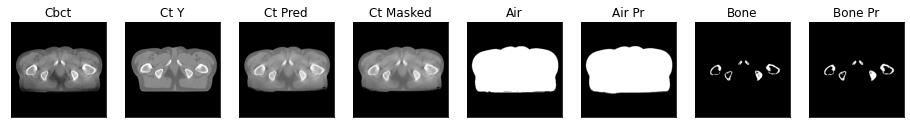

ssim score = 0.7928494811058044
psnr score = 21.381271362304688
snr score = 11.722679138183594
mae error = 0.032448504120111465
air dice score = 0.9945368459390602
bone dice score = 0.9245794899633826
contour dice score = 0.5812599062919617


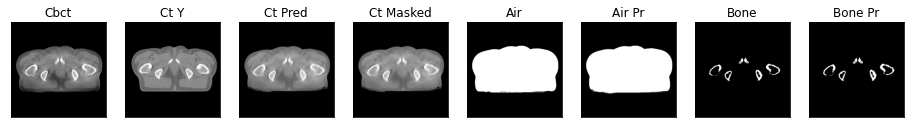

ssim score = 0.7961316108703613
psnr score = 21.315439224243164
snr score = 11.670957565307617
mae error = 0.03254679590463638
air dice score = 0.9947601424964594
bone dice score = 0.9354437133214397
contour dice score = 0.5452620387077332


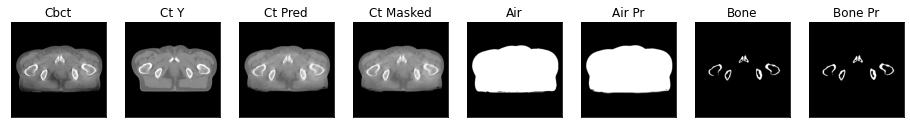

ssim score = 0.7961225509643555
psnr score = 21.243412017822266
snr score = 11.656938552856445
mae error = 0.03355693817138672
air dice score = 0.9947674719809395
bone dice score = 0.92685274302331
contour dice score = 0.541866660118103


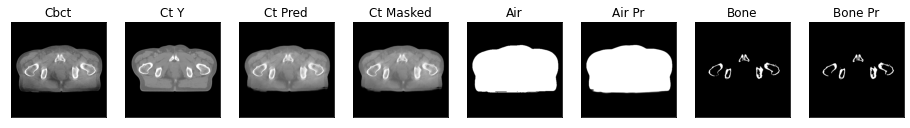

16it [00:20,  1.27s/it]

ssim score = 0.7889193296432495
psnr score = 21.041929244995117
snr score = 11.55401611328125
mae error = 0.035258062183856964
air dice score = 0.9944895042275882
bone dice score = 0.9205521472404823
contour dice score = 0.4973767101764679


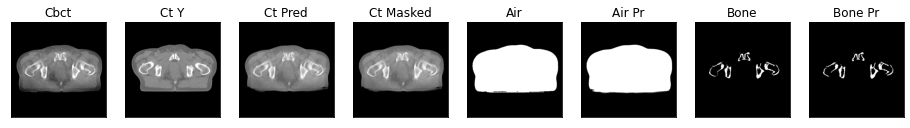

ssim score = 0.7819768786430359
psnr score = 20.95970916748047
snr score = 11.507624626159668
mae error = 0.03650759905576706
air dice score = 0.993778879165704
bone dice score = 0.9138264622724538
contour dice score = 0.48536455631256104


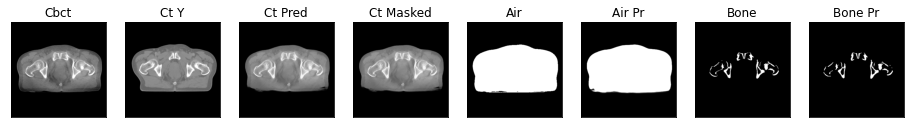

ssim score = 0.7733805775642395
psnr score = 20.900253295898438
snr score = 11.480875015258789
mae error = 0.03682291507720947
air dice score = 0.9945423760861578
bone dice score = 0.8795986622090357
contour dice score = 0.5659164190292358


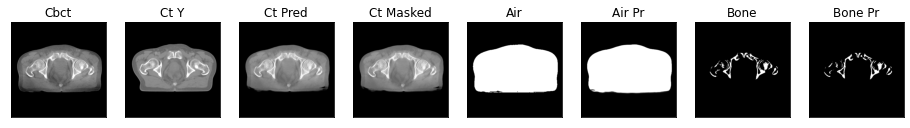

ssim score = 0.7727991938591003
psnr score = 20.93601417541504
snr score = 11.633452415466309
mae error = 0.03669625520706177
air dice score = 0.9953977194669636
bone dice score = 0.9176192353183863
contour dice score = 0.5969361066818237


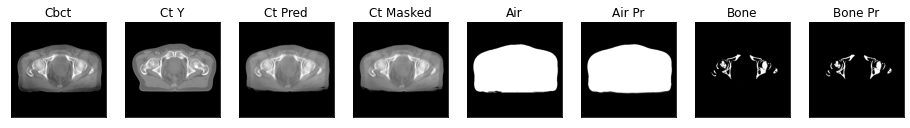

17it [00:21,  1.24s/it]

ssim score = 0.7765041589736938
psnr score = 20.969316482543945
snr score = 11.650768280029297
mae error = 0.03621496632695198
air dice score = 0.9955293935935647
bone dice score = 0.9141336321625699
contour dice score = 0.6228974461555481


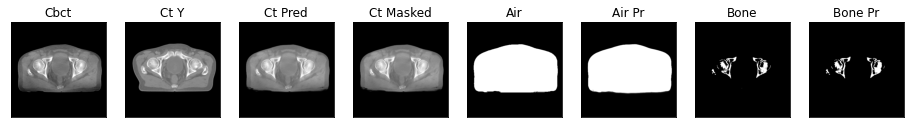

ssim score = 0.7908980250358582
psnr score = 21.470632553100586
snr score = 11.952920913696289
mae error = 0.03324541449546814
air dice score = 0.9952609884224188
bone dice score = 0.9215773150210962
contour dice score = 0.6275346875190735


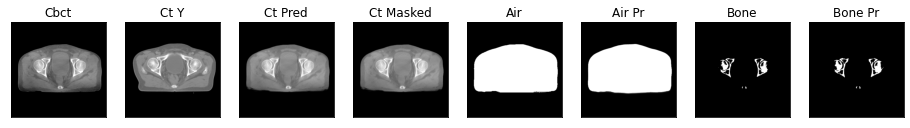

ssim score = 0.8073079586029053
psnr score = 22.11871337890625
snr score = 12.430609703063965
mae error = 0.030530717223882675
air dice score = 0.9950557722575831
bone dice score = 0.9402368493536183
contour dice score = 0.6217672228813171


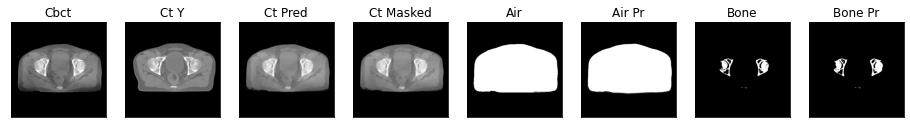

ssim score = 0.8147519826889038
psnr score = 22.47594451904297
snr score = 12.802008628845215
mae error = 0.02933298610150814
air dice score = 0.99441197798917
bone dice score = 0.9519843851665324
contour dice score = 0.5783003568649292


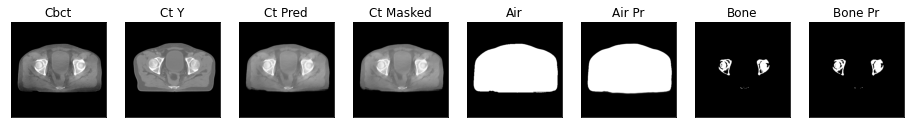

18it [00:22,  1.22s/it]

ssim score = 0.8168216943740845
psnr score = 22.536184310913086
snr score = 12.94407844543457
mae error = 0.029432134702801704
air dice score = 0.9941278594771292
bone dice score = 0.96045952444616
contour dice score = 0.5886178612709045


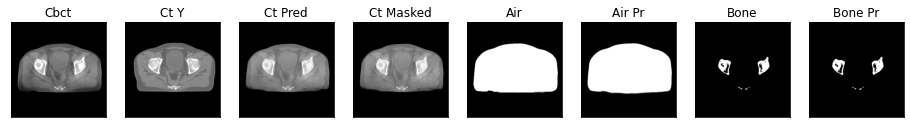

ssim score = 0.8154925107955933
psnr score = 22.43604850769043
snr score = 12.936113357543945
mae error = 0.030470294877886772
air dice score = 0.9945130548524687
bone dice score = 0.9466275659831873
contour dice score = 0.5703380703926086


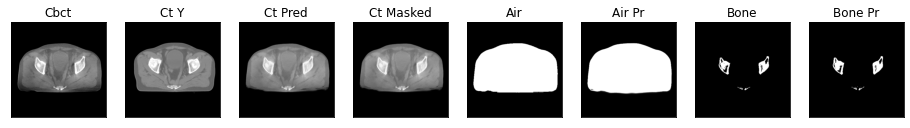

ssim score = 0.810928463935852
psnr score = 22.84803581237793
snr score = 13.284672737121582
mae error = 0.029074519872665405
air dice score = 0.9951168321188928
bone dice score = 0.9592760181002056
contour dice score = 0.605800211429596


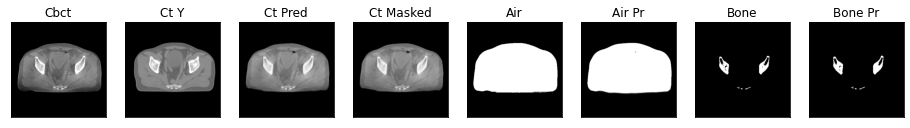

ssim score = 0.816622793674469
psnr score = 23.02100372314453
snr score = 13.421248435974121
mae error = 0.028194572776556015
air dice score = 0.9957675898963941
bone dice score = 0.9542438002103695
contour dice score = 0.5898666381835938


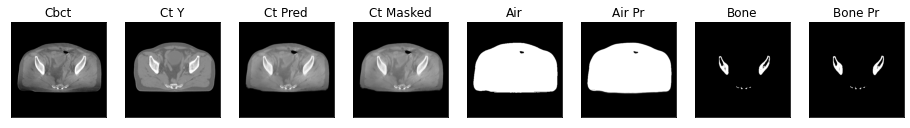

19it [00:23,  1.26s/it]

ssim score = 0.8157323002815247
psnr score = 22.76082992553711
snr score = 13.198820114135742
mae error = 0.02951810508966446
air dice score = 0.9956132179333043
bone dice score = 0.9427969534930676
contour dice score = 0.5994722843170166


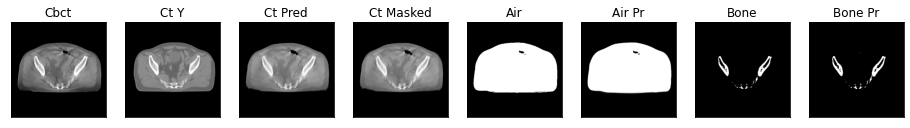

ssim score = 0.8137041926383972
psnr score = 22.651662826538086
snr score = 13.2201566696167
mae error = 0.030178988352417946
air dice score = 0.9955493010283272
bone dice score = 0.9384615384624316
contour dice score = 0.6142321825027466


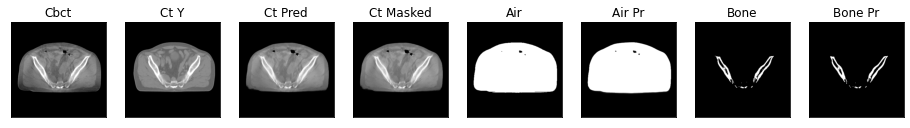

ssim score = 0.8161596655845642
psnr score = 22.563701629638672
snr score = 13.149944305419922
mae error = 0.03045683540403843
air dice score = 0.9959915234763994
bone dice score = 0.916640452973944
contour dice score = 0.5970951914787292


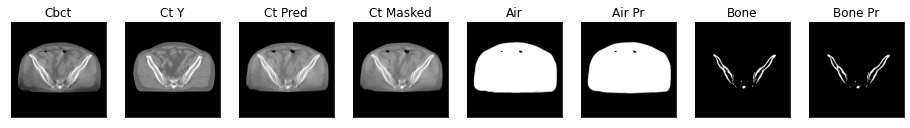

ssim score = 0.8202833533287048
psnr score = 22.997772216796875
snr score = 13.572746276855469
mae error = 0.029236307367682457
air dice score = 0.9960348658349034
bone dice score = 0.9233638521545716
contour dice score = 0.5945945978164673


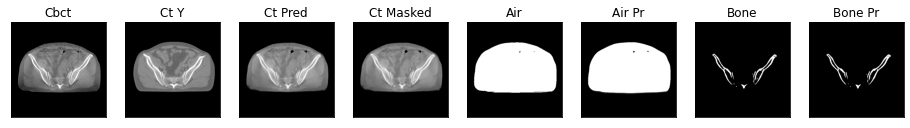

20it [00:25,  1.24s/it]

ssim score = 0.8222077488899231
psnr score = 22.973478317260742
snr score = 13.547712326049805
mae error = 0.029052847996354103
air dice score = 0.9956855513144953
bone dice score = 0.9185763042431566
contour dice score = 0.6041439771652222


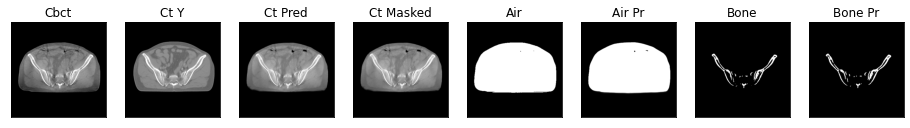

ssim score = 0.8784133195877075
psnr score = 23.895774841308594
snr score = 14.329909324645996
mae error = 0.020716708153486252
air dice score = 0.9971192105682022
bone dice score = 0.9150976909444015
contour dice score = 0.4837852120399475


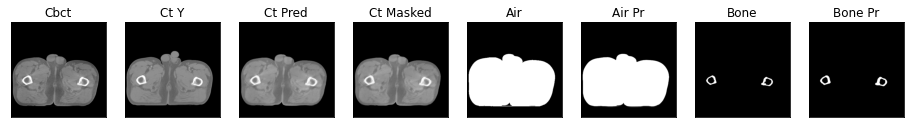

ssim score = 0.8806337118148804
psnr score = 24.29166603088379
snr score = 14.790190696716309
mae error = 0.019998660311102867
air dice score = 0.9968139018239054
bone dice score = 0.9032882011636593
contour dice score = 0.4444444477558136


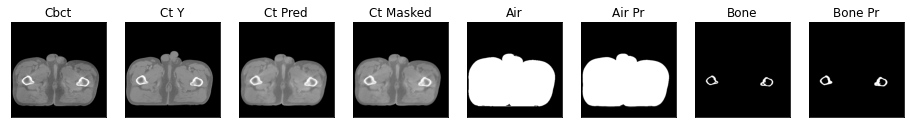

ssim score = 0.8881487846374512
psnr score = 25.82187843322754
snr score = 16.459617614746094
mae error = 0.018044566735625267
air dice score = 0.9974835492896126
bone dice score = 0.9291338582692247
contour dice score = 0.4472745656967163


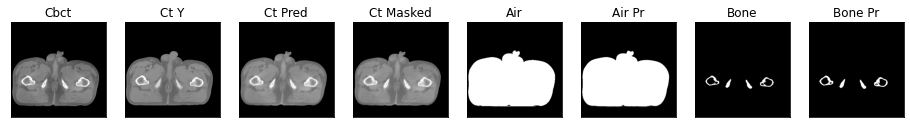

21it [00:26,  1.22s/it]

ssim score = 0.8883301019668579
psnr score = 25.84630012512207
snr score = 16.605531692504883
mae error = 0.018418841063976288
air dice score = 0.9978614033859834
bone dice score = 0.9232026143806535
contour dice score = 0.47246524691581726


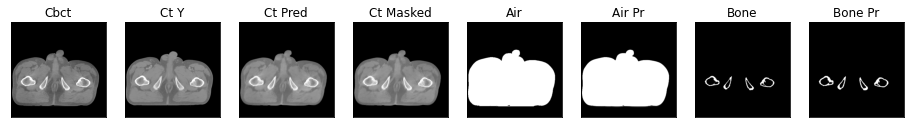

ssim score = 0.8856547474861145
psnr score = 25.760425567626953
snr score = 16.54383087158203
mae error = 0.01849433407187462
air dice score = 0.9980759085125547
bone dice score = 0.9158760278322606
contour dice score = 0.46936655044555664


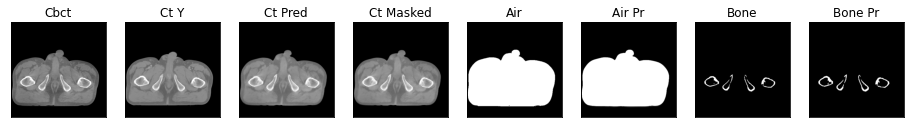

ssim score = 0.8852272033691406
psnr score = 25.558900833129883
snr score = 16.337907791137695
mae error = 0.01876542903482914
air dice score = 0.9982483064378628
bone dice score = 0.914241665062358
contour dice score = 0.4686192572116852


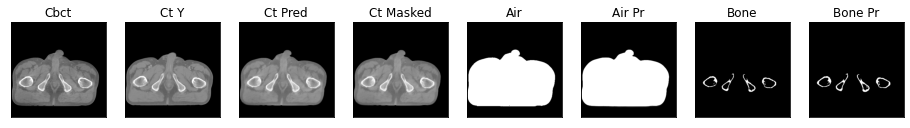

ssim score = 0.8852142095565796
psnr score = 25.06682586669922
snr score = 15.852088928222656
mae error = 0.019594378769397736
air dice score = 0.9977930414985653
bone dice score = 0.9218989280259974
contour dice score = 0.4539231061935425


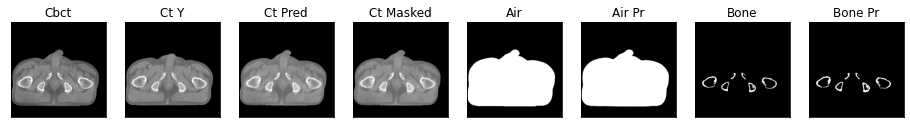

22it [00:27,  1.27s/it]

ssim score = 0.882778525352478
psnr score = 24.79788589477539
snr score = 15.561589241027832
mae error = 0.01979794166982174
air dice score = 0.9978991759498299
bone dice score = 0.932592876293899
contour dice score = 0.474683552980423


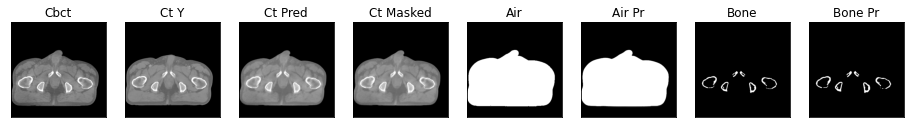

ssim score = 0.8829547762870789
psnr score = 24.80191421508789
snr score = 15.582529067993164
mae error = 0.020074399188160896
air dice score = 0.997614255406783
bone dice score = 0.9381686310074675
contour dice score = 0.47346073389053345


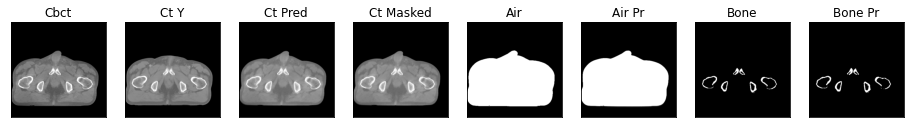

ssim score = 0.8848323822021484
psnr score = 25.098308563232422
snr score = 15.947519302368164
mae error = 0.02003605291247368
air dice score = 0.9975270889077865
bone dice score = 0.9393183707408259
contour dice score = 0.5077498555183411


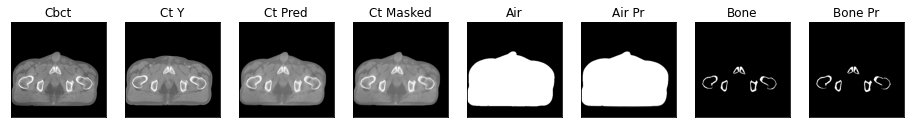

ssim score = 0.8870090842247009
psnr score = 25.402814865112305
snr score = 16.33338165283203
mae error = 0.020394781604409218
air dice score = 0.9971567099295857
bone dice score = 0.9369956548737276
contour dice score = 0.5271651148796082


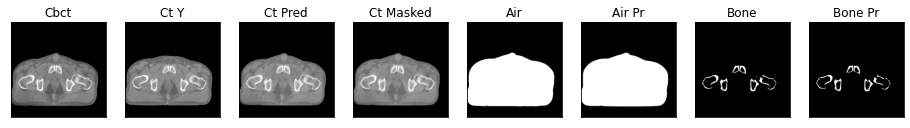

23it [00:28,  1.24s/it]

ssim score = 0.8873860836029053
psnr score = 25.570941925048828
snr score = 16.55221176147461
mae error = 0.020594218745827675
air dice score = 0.9971135771980486
bone dice score = 0.9077884468845026
contour dice score = 0.5909579992294312


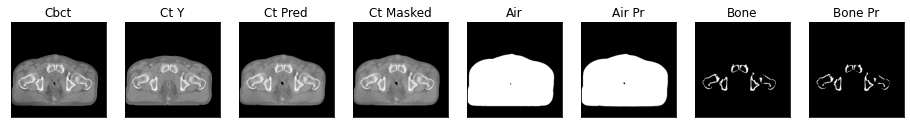

ssim score = 0.8894243836402893
psnr score = 25.7150936126709
snr score = 16.812631607055664
mae error = 0.021372612565755844
air dice score = 0.9974126778783979
bone dice score = 0.8626698168951171
contour dice score = 0.556812047958374


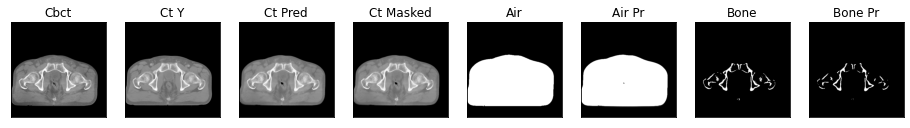

ssim score = 0.8890723586082458
psnr score = 25.30023956298828
snr score = 16.359542846679688
mae error = 0.021279241889715195
air dice score = 0.9977711325977824
bone dice score = 0.8763516690193331
contour dice score = 0.5433962345123291


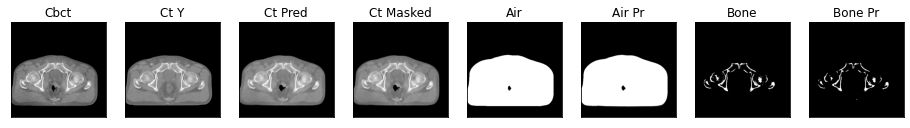

ssim score = 0.8811094164848328
psnr score = 24.552316665649414
snr score = 15.515949249267578
mae error = 0.021746674552559853
air dice score = 0.9973210073012568
bone dice score = 0.8807549328012474
contour dice score = 0.47757968306541443


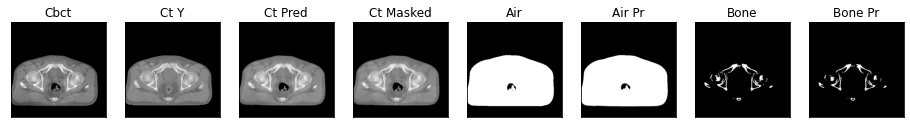

24it [00:30,  1.22s/it]

ssim score = 0.8845819234848022
psnr score = 24.44696617126465
snr score = 15.250840187072754
mae error = 0.020539097487926483
air dice score = 0.9970529028102125
bone dice score = 0.9188198033019033
contour dice score = 0.5043290257453918


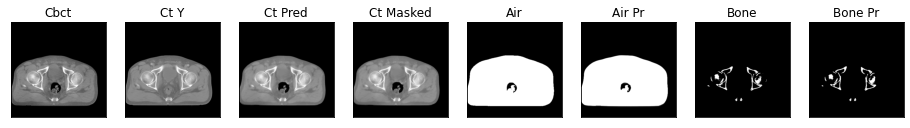

ssim score = 0.8835601210594177
psnr score = 24.229448318481445
snr score = 14.916897773742676
mae error = 0.02040710300207138
air dice score = 0.9975092791560872
bone dice score = 0.9138276553120603
contour dice score = 0.47634583711624146


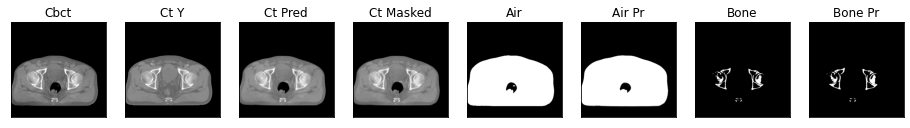

ssim score = 0.8774793148040771
psnr score = 24.10370635986328
snr score = 14.746061325073242
mae error = 0.020672395825386047
air dice score = 0.9979938587512811
bone dice score = 0.9318181818192579
contour dice score = 0.4863685965538025


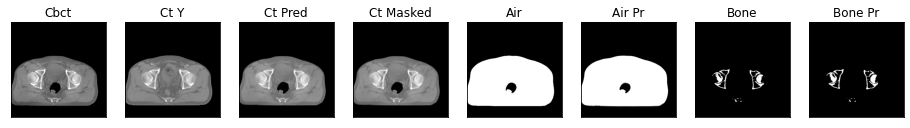

ssim score = 0.8693631887435913
psnr score = 23.567800521850586
snr score = 14.21683120727539
mae error = 0.022397594526410103
air dice score = 0.9980650662468861
bone dice score = 0.9419827861022955
contour dice score = 0.4849480092525482


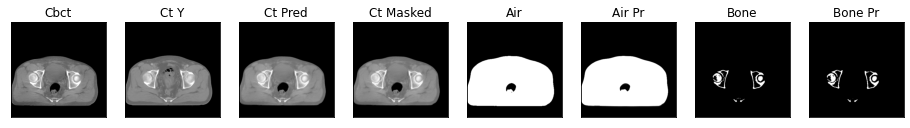

25it [00:31,  1.26s/it]

ssim score = 0.8711312413215637
psnr score = 23.209224700927734
snr score = 13.888355255126953
mae error = 0.023756779730319977
air dice score = 0.997814872013934
bone dice score = 0.9507246376819112
contour dice score = 0.48328766226768494


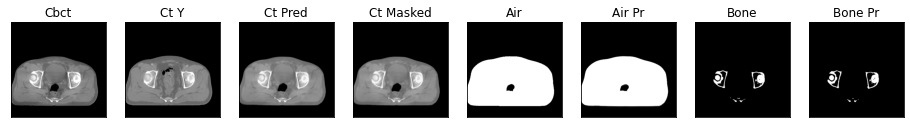

ssim score = 0.8761991858482361
psnr score = 23.825490951538086
snr score = 14.462037086486816
mae error = 0.02210545912384987
air dice score = 0.9974570987958153
bone dice score = 0.9452284946245761
contour dice score = 0.4989035129547119


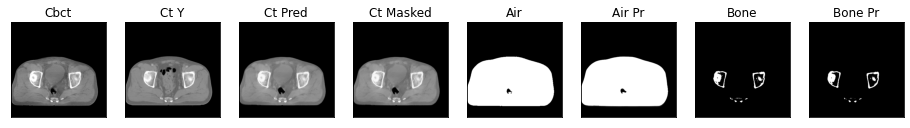

ssim score = 0.8765440583229065
psnr score = 24.100732803344727
snr score = 14.647074699401855
mae error = 0.020890861749649048
air dice score = 0.9979656549849706
bone dice score = 0.9413284132852153
contour dice score = 0.48737651109695435


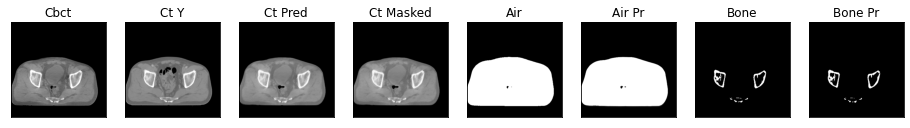

ssim score = 0.8774436116218567
psnr score = 23.859922409057617
snr score = 14.34053897857666
mae error = 0.02117268368601799
air dice score = 0.9977537063844675
bone dice score = 0.9527483124406413
contour dice score = 0.5197802186012268


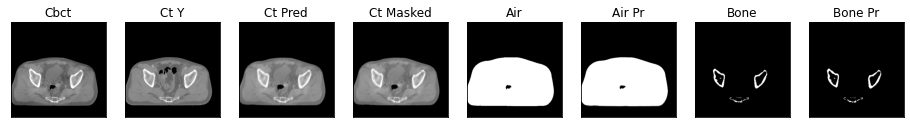

26it [00:32,  1.23s/it]

ssim score = 0.8736158013343811
psnr score = 23.850048065185547
snr score = 14.33035945892334
mae error = 0.021520012989640236
air dice score = 0.9973346743776739
bone dice score = 0.9514261019887393
contour dice score = 0.5187224745750427


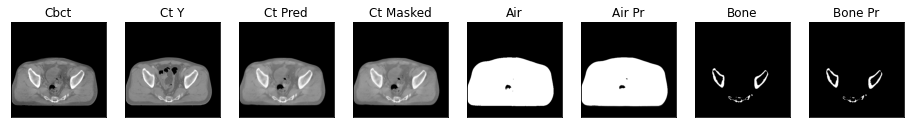

ssim score = 0.8665309548377991
psnr score = 23.55384063720703
snr score = 14.110321998596191
mae error = 0.023440280929207802
air dice score = 0.9967757495747571
bone dice score = 0.9320501603976079
contour dice score = 0.5719026327133179


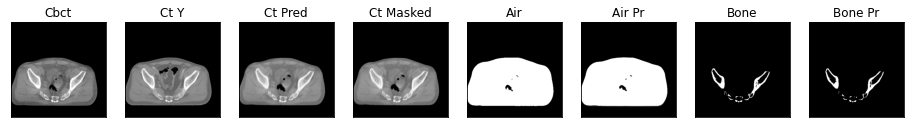

ssim score = 0.8693298697471619
psnr score = 23.64525604248047
snr score = 14.237317085266113
mae error = 0.02333628199994564
air dice score = 0.9964390983592623
bone dice score = 0.9145381747906318
contour dice score = 0.565578281879425


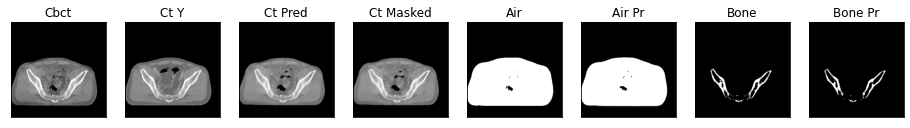

ssim score = 0.8701251149177551
psnr score = 24.352081298828125
snr score = 14.882444381713867
mae error = 0.0216941237449646
air dice score = 0.9972132426708307
bone dice score = 0.9059080962814601
contour dice score = 0.5188888907432556


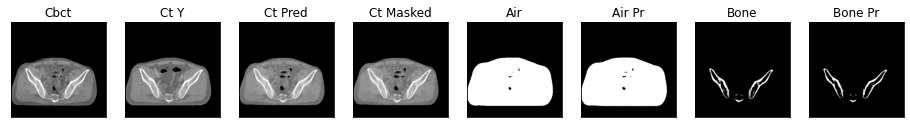

27it [00:33,  1.21s/it]

ssim score = 0.8641814589500427
psnr score = 24.212547302246094
snr score = 14.681649208068848
mae error = 0.02185996249318123
air dice score = 0.9969495597169079
bone dice score = 0.9037555116329062
contour dice score = 0.476992130279541


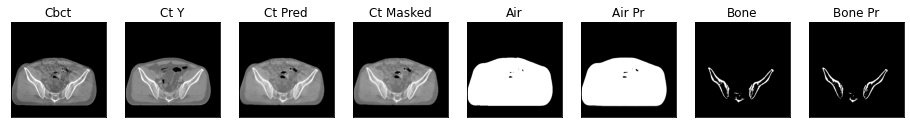

ssim score = 0.7995583415031433
psnr score = 22.420246124267578
snr score = 14.1175537109375
mae error = 0.03178485110402107
air dice score = 0.9967800278708472
bone dice score = 0.9520651190849543
contour dice score = 0.392070472240448


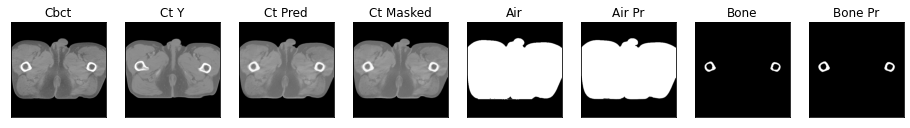

ssim score = 0.7913103103637695
psnr score = 22.116500854492188
snr score = 13.918099403381348
mae error = 0.033301107585430145
air dice score = 0.9968987311919267
bone dice score = 0.9509617989717973
contour dice score = 0.40888887643814087


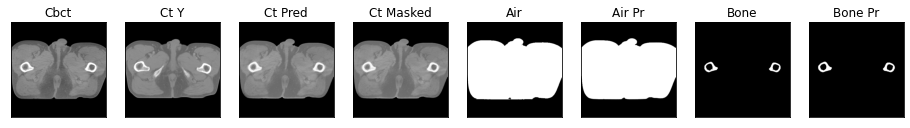

ssim score = 0.7886710166931152
psnr score = 21.835548400878906
snr score = 13.76510238647461
mae error = 0.035852838307619095
air dice score = 0.9969504133688255
bone dice score = 0.943085912141461
contour dice score = 0.39372196793556213


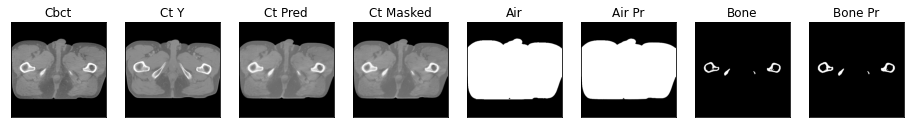

28it [00:35,  1.26s/it]

ssim score = 0.7834891676902771
psnr score = 21.58293914794922
snr score = 13.544783592224121
mae error = 0.037981096655130386
air dice score = 0.9969001060644257
bone dice score = 0.9606195419350697
contour dice score = 0.35087719559669495


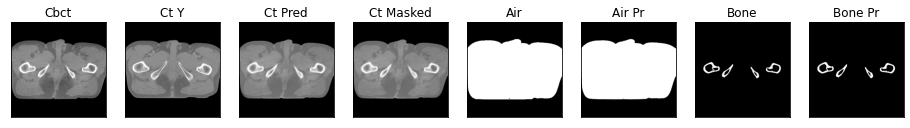

ssim score = 0.7750744819641113
psnr score = 21.45869255065918
snr score = 13.450775146484375
mae error = 0.039104901254177094
air dice score = 0.9967968202010774
bone dice score = 0.9473173884947105
contour dice score = 0.365115225315094


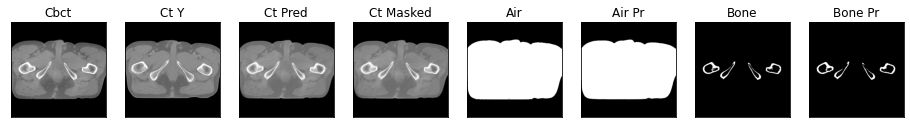

ssim score = 0.7703588604927063
psnr score = 21.294710159301758
snr score = 13.321208953857422
mae error = 0.04043646529316902
air dice score = 0.9968649845580113
bone dice score = 0.9479085678751685
contour dice score = 0.38388410210609436


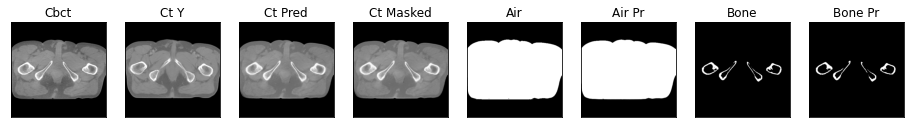

ssim score = 0.7634593844413757
psnr score = 20.97563934326172
snr score = 13.022446632385254
mae error = 0.0422104187309742
air dice score = 0.9966271327144925
bone dice score = 0.9434329395421344
contour dice score = 0.36609557271003723


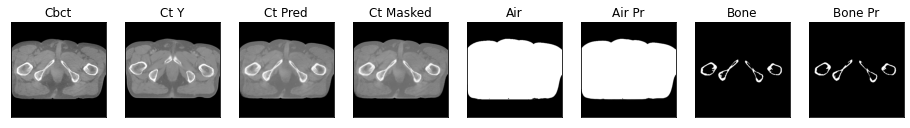

29it [00:36,  1.24s/it]

ssim score = 0.7642130255699158
psnr score = 20.97481918334961
snr score = 13.06070327758789
mae error = 0.04208066314458847
air dice score = 0.9963896406446512
bone dice score = 0.9436053761958764
contour dice score = 0.402515709400177


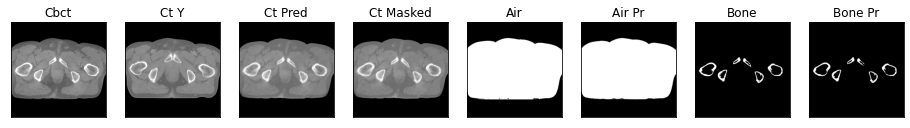

ssim score = 0.7625709772109985
psnr score = 21.023637771606445
snr score = 13.158199310302734
mae error = 0.04260450601577759
air dice score = 0.9957575055059721
bone dice score = 0.9367054368415376
contour dice score = 0.3766855299472809


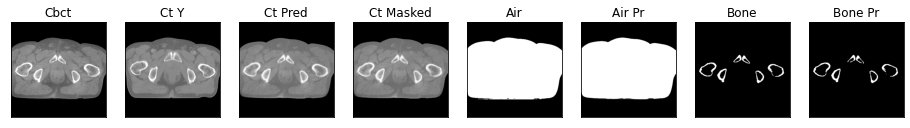

ssim score = 0.7534423470497131
psnr score = 20.77020835876465
snr score = 12.92738151550293
mae error = 0.044603075832128525
air dice score = 0.9958697553713479
bone dice score = 0.9288340336143798
contour dice score = 0.3785623013973236


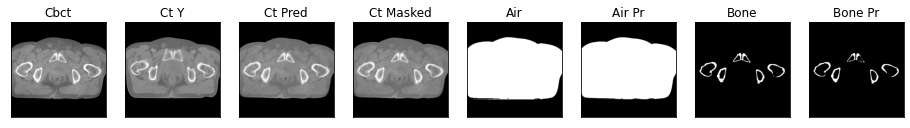

ssim score = 0.742772102355957
psnr score = 20.70661735534668
snr score = 12.906569480895996
mae error = 0.0460895299911499
air dice score = 0.9964052476449191
bone dice score = 0.9115375031159788
contour dice score = 0.3516390025615692


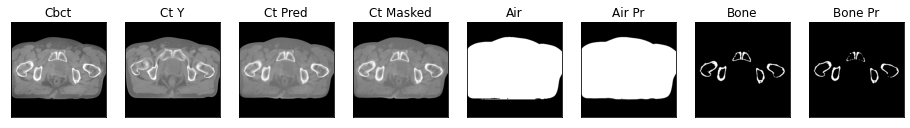

30it [00:37,  1.22s/it]

ssim score = 0.7464613914489746
psnr score = 20.75176429748535
snr score = 13.010053634643555
mae error = 0.04591049626469612
air dice score = 0.9964458320612466
bone dice score = 0.9002196785767115
contour dice score = 0.35876476764678955


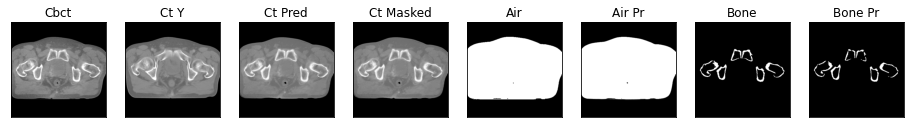

ssim score = 0.7432736754417419
psnr score = 20.727615356445312
snr score = 12.91053295135498
mae error = 0.04651429131627083
air dice score = 0.9966958704136513
bone dice score = 0.8455373806142766
contour dice score = 0.35235053300857544


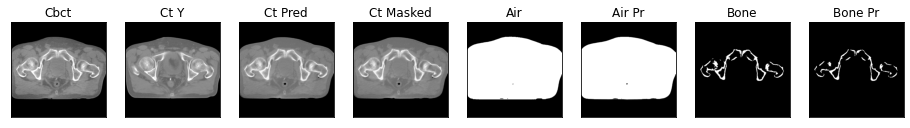

ssim score = 0.747041642665863
psnr score = 20.84039306640625
snr score = 12.91609001159668
mae error = 0.04571806266903877
air dice score = 0.9967888957944911
bone dice score = 0.8127060892524433
contour dice score = 0.3264557421207428


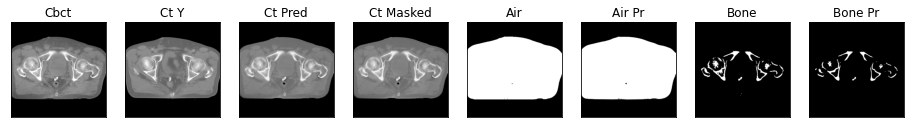

ssim score = 0.7596670985221863
psnr score = 21.244688034057617
snr score = 13.197298049926758
mae error = 0.04312333092093468
air dice score = 0.9972818575509091
bone dice score = 0.7776416880104927
contour dice score = 0.33547794818878174


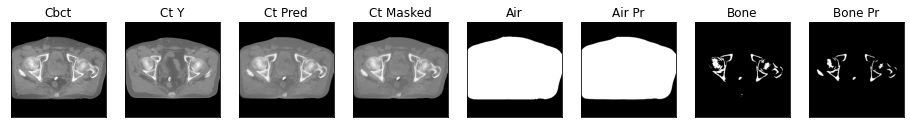

31it [00:38,  1.27s/it]

ssim score = 0.7628543972969055
psnr score = 21.431148529052734
snr score = 13.271329879760742
mae error = 0.041333843022584915
air dice score = 0.9973960287995766
bone dice score = 0.8523169241043191
contour dice score = 0.3231763541698456


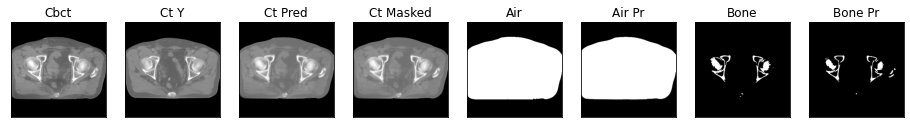

ssim score = 0.7592551708221436
psnr score = 21.618011474609375
snr score = 13.40754508972168
mae error = 0.039203427731990814
air dice score = 0.9973712856381886
bone dice score = 0.9113787911388322
contour dice score = 0.302552193403244


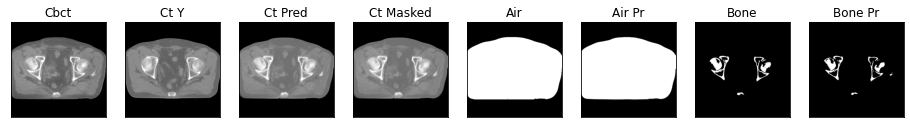

ssim score = 0.7602167725563049
psnr score = 21.423662185668945
snr score = 13.245351791381836
mae error = 0.04043920710682869
air dice score = 0.9975717157164614
bone dice score = 0.9181663837021146
contour dice score = 0.3083372116088867


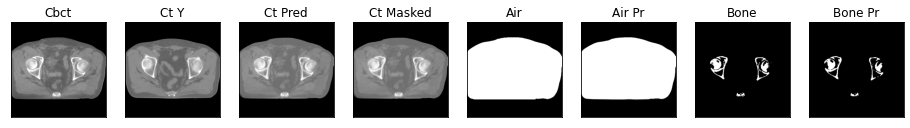

ssim score = 0.7578637003898621
psnr score = 21.1934757232666
snr score = 13.028641700744629
mae error = 0.04145025461912155
air dice score = 0.9976207415355561
bone dice score = 0.9287541103406557
contour dice score = 0.29549717903137207


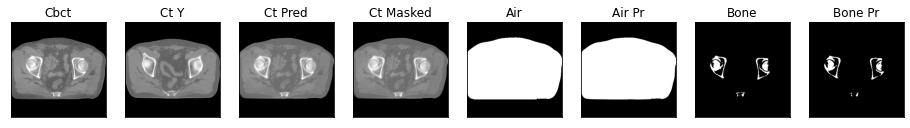

32it [00:40,  1.25s/it]

ssim score = 0.755464494228363
psnr score = 20.878536224365234
snr score = 12.572212219238281
mae error = 0.042802609503269196
air dice score = 0.9971972371090514
bone dice score = 0.9290823130084969
contour dice score = 0.2522437274456024


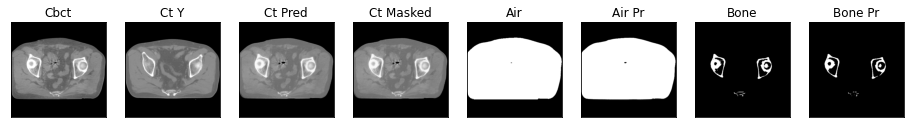

ssim score = 0.7642154693603516
psnr score = 20.98974609375
snr score = 12.624113082885742
mae error = 0.04127373546361923
air dice score = 0.9972777411143601
bone dice score = 0.9438108484013378
contour dice score = 0.2688121199607849


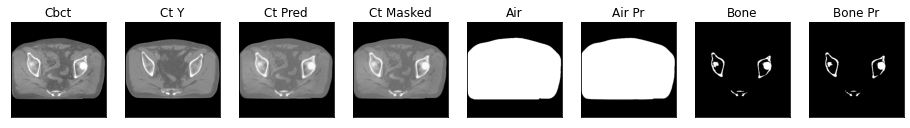

ssim score = 0.7587746381759644
psnr score = 21.236148834228516
snr score = 12.896163940429688
mae error = 0.03930294141173363
air dice score = 0.9973177966854377
bone dice score = 0.9384814335869485
contour dice score = 0.28341230750083923


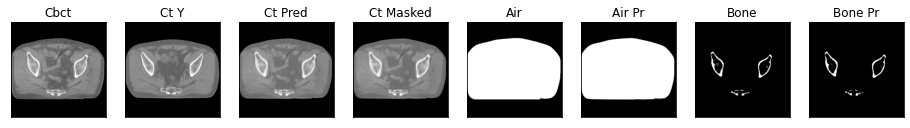

ssim score = 0.7514199018478394
psnr score = 20.991252899169922
snr score = 12.724081039428711
mae error = 0.04014825075864792
air dice score = 0.9969641050062522
bone dice score = 0.9459975690233374
contour dice score = 0.2625592350959778


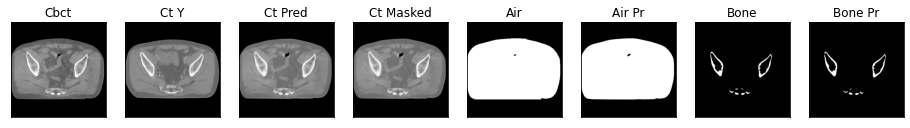

33it [00:41,  1.22s/it]

ssim score = 0.7423553466796875
psnr score = 20.473960876464844
snr score = 12.336019515991211
mae error = 0.043002884835004807
air dice score = 0.9966089102978907
bone dice score = 0.9462154650981491
contour dice score = 0.2550143301486969


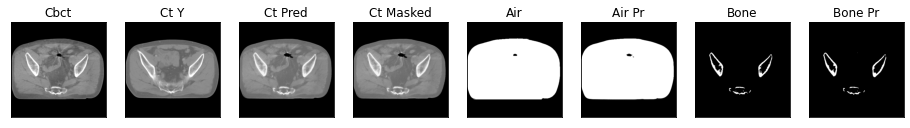

ssim score = 0.7382311820983887
psnr score = 20.349960327148438
snr score = 12.245978355407715
mae error = 0.04413272812962532
air dice score = 0.9964021623185283
bone dice score = 0.9376809385961042
contour dice score = 0.24219125509262085


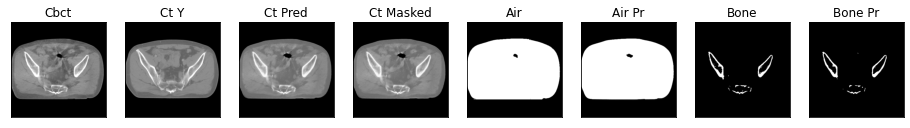

ssim score = 0.7303688526153564
psnr score = 20.439674377441406
snr score = 12.305900573730469
mae error = 0.04523957148194313
air dice score = 0.996774193548389
bone dice score = 0.9075759518022359
contour dice score = 0.23025047779083252


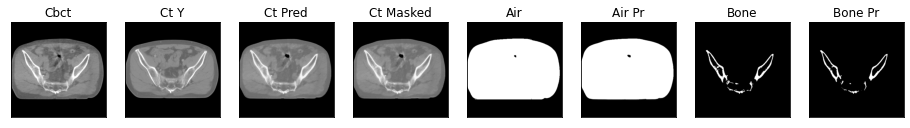

ssim score = 0.7293700575828552
psnr score = 20.7741641998291
snr score = 12.577013969421387
mae error = 0.04314597323536873
air dice score = 0.9972311924048656
bone dice score = 0.893163575977122
contour dice score = 0.2477019876241684


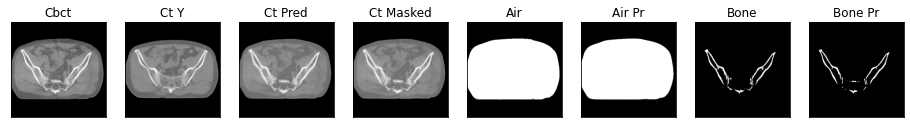

34it [00:42,  1.27s/it]

ssim score = 0.836588978767395
psnr score = 22.38520050048828
snr score = 13.862594604492188
mae error = 0.032381802797317505
air dice score = 0.9977890878874677
bone dice score = 0.909984871408094
contour dice score = 0.43281328678131104


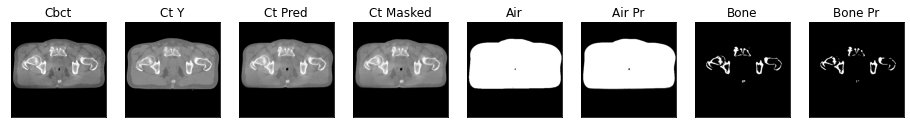

ssim score = 0.8426268696784973
psnr score = 22.45656967163086
snr score = 13.973970413208008
mae error = 0.031713176518678665
air dice score = 0.9979118519124034
bone dice score = 0.8927813163496181
contour dice score = 0.4086781144142151


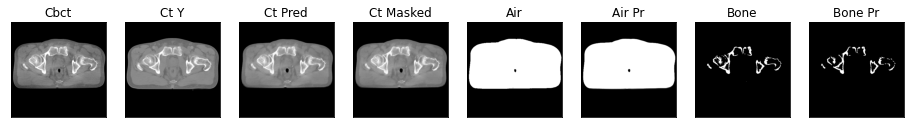

ssim score = 0.842621386051178
psnr score = 22.570707321166992
snr score = 14.095897674560547
mae error = 0.03176570311188698
air dice score = 0.997560395096991
bone dice score = 0.8813134826787072
contour dice score = 0.4002026319503784


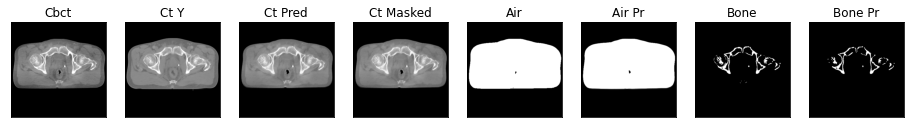

ssim score = 0.8481953144073486
psnr score = 22.61101722717285
snr score = 14.077787399291992
mae error = 0.030655542388558388
air dice score = 0.9975526406112447
bone dice score = 0.8955262814673859
contour dice score = 0.4276282489299774


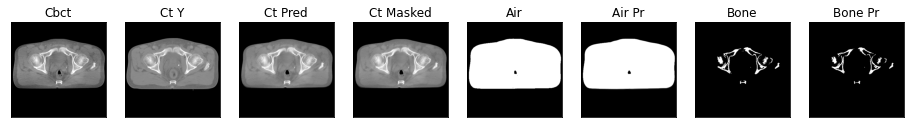

35it [00:43,  1.24s/it]

ssim score = 0.8544361591339111
psnr score = 22.844884872436523
snr score = 14.156030654907227
mae error = 0.027847809717059135
air dice score = 0.9974933217602138
bone dice score = 0.9095514826417889
contour dice score = 0.44875064492225647


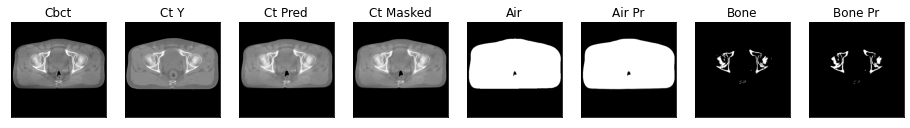

ssim score = 0.8574736714363098
psnr score = 22.966367721557617
snr score = 14.256710052490234
mae error = 0.02723446488380432
air dice score = 0.9974875314058593
bone dice score = 0.9230119634071356
contour dice score = 0.4634270966053009


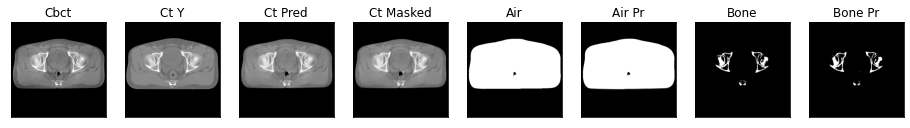

ssim score = 0.8528442978858948
psnr score = 22.84894561767578
snr score = 14.1236572265625
mae error = 0.027631161734461784
air dice score = 0.9969898558140957
bone dice score = 0.9327986725673009
contour dice score = 0.4797123670578003


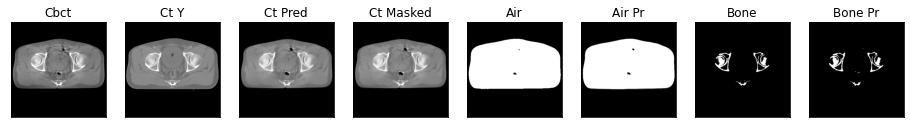

ssim score = 0.8434949517250061
psnr score = 22.278118133544922
snr score = 13.562196731567383
mae error = 0.029595140367746353
air dice score = 0.9973548172556627
bone dice score = 0.9307572979843357
contour dice score = 0.48556700348854065


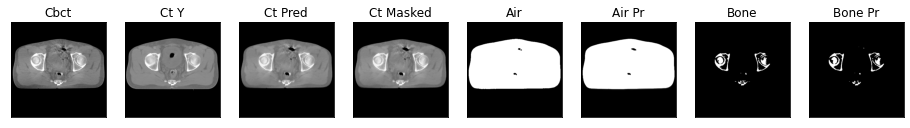

36it [00:44,  1.22s/it]

ssim score = 0.8362232446670532
psnr score = 21.859960556030273
snr score = 13.199816703796387
mae error = 0.03186158835887909
air dice score = 0.9964765520220071
bone dice score = 0.940375260598466
contour dice score = 0.4676668345928192


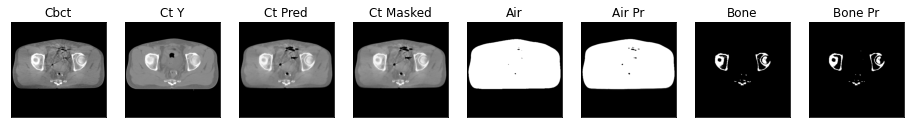

ssim score = 0.8364830613136292
psnr score = 21.847246170043945
snr score = 13.165173530578613
mae error = 0.03229732811450958
air dice score = 0.9962853576104526
bone dice score = 0.9333906317156082
contour dice score = 0.47480520606040955


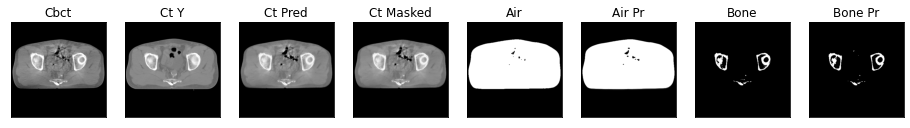

ssim score = 0.8357067108154297
psnr score = 21.441390991210938
snr score = 12.688546180725098
mae error = 0.032242562621831894
air dice score = 0.9968003787618483
bone dice score = 0.9232224499460315
contour dice score = 0.4467640817165375


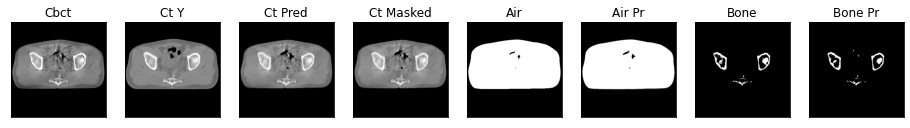

ssim score = 0.8391808867454529
psnr score = 21.66862678527832
snr score = 12.87188720703125
mae error = 0.03112339973449707
air dice score = 0.9965299539874982
bone dice score = 0.9316480957935864
contour dice score = 0.4509701132774353


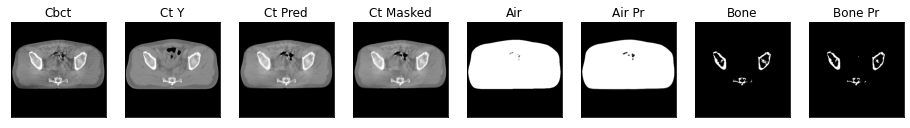

37it [00:46,  1.27s/it]

ssim score = 0.8382188677787781
psnr score = 21.83509635925293
snr score = 13.037260055541992
mae error = 0.03057258017361164
air dice score = 0.9969470099107138
bone dice score = 0.9396537777068491
contour dice score = 0.4968421161174774


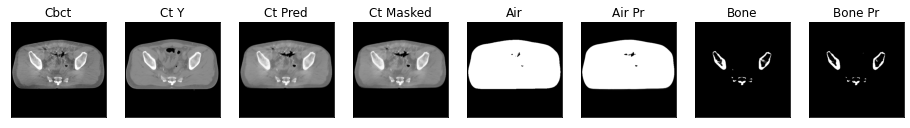

ssim score = 0.831701934337616
psnr score = 21.651517868041992
snr score = 12.867040634155273
mae error = 0.031525395810604095
air dice score = 0.9960899240350163
bone dice score = 0.9381987577649348
contour dice score = 0.4599156081676483


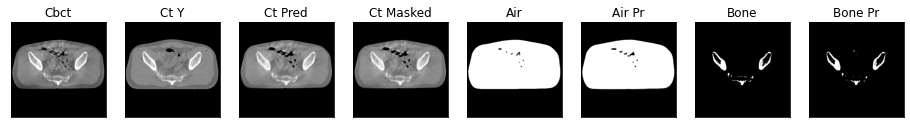

ssim score = 0.8278692960739136
psnr score = 21.46957015991211
snr score = 12.74029541015625
mae error = 0.033216703683137894
air dice score = 0.9965068275643089
bone dice score = 0.9174458990125909
contour dice score = 0.4503171145915985


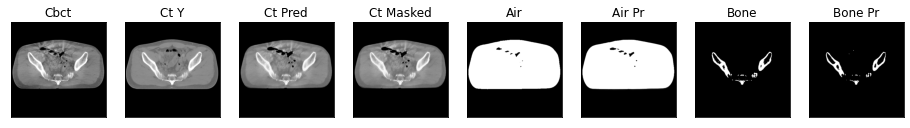

ssim score = 0.830248236656189
psnr score = 21.2429256439209
snr score = 12.533023834228516
mae error = 0.034111712127923965
air dice score = 0.9965401681819619
bone dice score = 0.9001394700153398
contour dice score = 0.4366719722747803


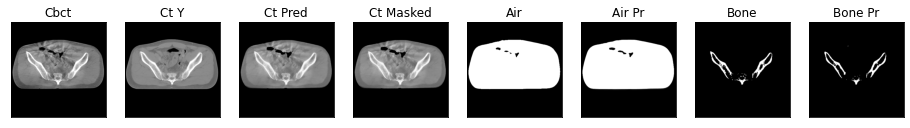

38it [00:47,  1.24s/it]

ssim score = 0.8341756463050842
psnr score = 21.38124656677246
snr score = 12.61660385131836
mae error = 0.03250405192375183
air dice score = 0.9962006668217445
bone dice score = 0.8990021167236316
contour dice score = 0.3759957551956177


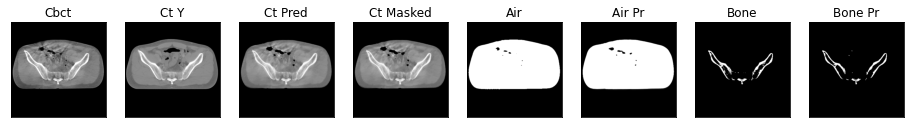

ssim score = 0.8383132815361023
psnr score = 21.864967346191406
snr score = 13.063972473144531
mae error = 0.030861811712384224
air dice score = 0.9966998233708309
bone dice score = 0.8878033887973164
contour dice score = 0.38633936643600464


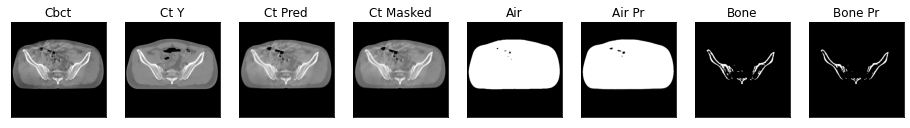

ssim score = 0.8431363701820374
psnr score = 22.094100952148438
snr score = 13.293176651000977
mae error = 0.029654303565621376
air dice score = 0.9967829706746484
bone dice score = 0.8768377253831229
contour dice score = 0.36012861132621765


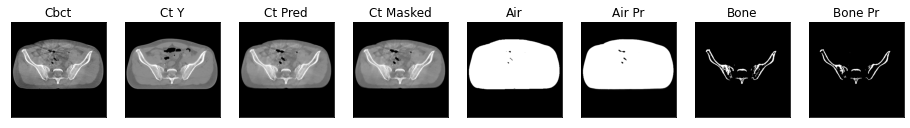

ssim score = 0.8390757441520691
psnr score = 22.01512336730957
snr score = 13.212779998779297
mae error = 0.02991928718984127
air dice score = 0.9964742245623872
bone dice score = 0.8856705194278559
contour dice score = 0.36206895112991333


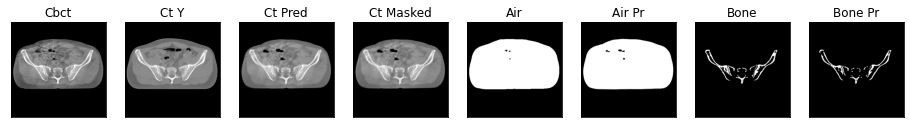

39it [00:48,  1.22s/it]

ssim score = 0.8259373307228088
psnr score = 21.313949584960938
snr score = 12.516641616821289
mae error = 0.03228987380862236
air dice score = 0.9957822354931543
bone dice score = 0.8652019844101317
contour dice score = 0.3425474166870117


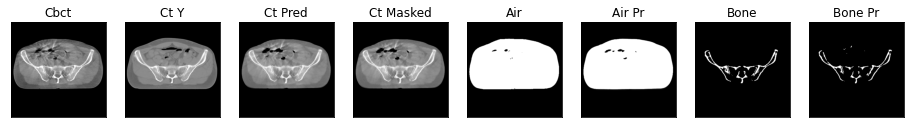

ssim score = 0.820583164691925
psnr score = 20.949995040893555
snr score = 12.135416030883789
mae error = 0.03348928689956665
air dice score = 0.994385898883457
bone dice score = 0.8601936218698719
contour dice score = 0.32279172539711


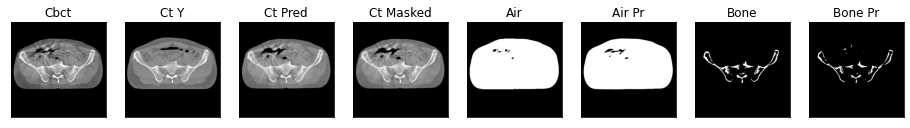

ssim score = 0.8158243894577026
psnr score = 20.816150665283203
snr score = 11.98294734954834
mae error = 0.03436245396733284
air dice score = 0.9949269719921703
bone dice score = 0.8484110885754103
contour dice score = 0.3347969353199005


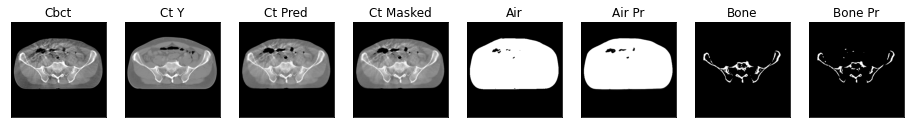

ssim score = 0.8069993257522583
psnr score = 20.5135498046875
snr score = 11.634407043457031
mae error = 0.03544439747929573
air dice score = 0.995114559244852
bone dice score = 0.8331562167928646
contour dice score = 0.3337016701698303


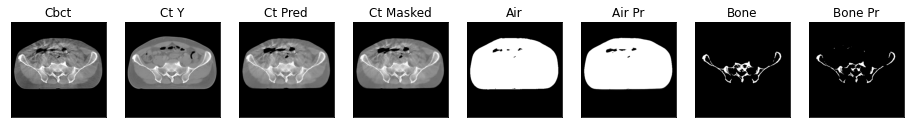

40it [00:50,  1.27s/it]

ssim score = 0.8027915954589844
psnr score = 20.530250549316406
snr score = 11.597309112548828
mae error = 0.035285260528326035
air dice score = 0.9946964952474615
bone dice score = 0.8499363057343957
contour dice score = 0.30760687589645386


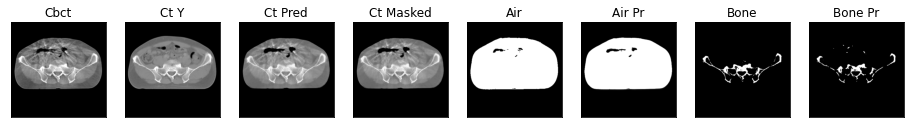

ssim score = 0.7963488698005676
psnr score = 20.234086990356445
snr score = 11.331610679626465
mae error = 0.036997128278017044
air dice score = 0.9949783935634346
bone dice score = 0.8775434702197861
contour dice score = 0.34671124815940857


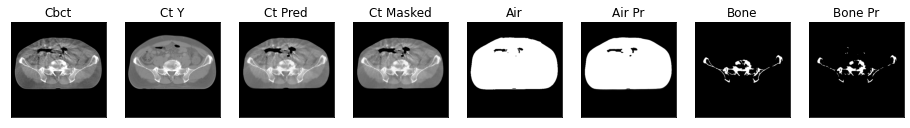

ssim score = 0.789313554763794
psnr score = 20.0751895904541
snr score = 11.117487907409668
mae error = 0.0367848165333271
air dice score = 0.9953047900707109
bone dice score = 0.8765226311081353
contour dice score = 0.37973272800445557


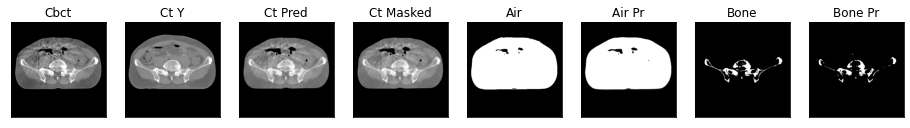

ssim score = 0.7992416620254517
psnr score = 20.82707977294922
snr score = 11.721843719482422
mae error = 0.03302314504981041
air dice score = 0.9961652223134663
bone dice score = 0.9006849315081574
contour dice score = 0.3256855010986328


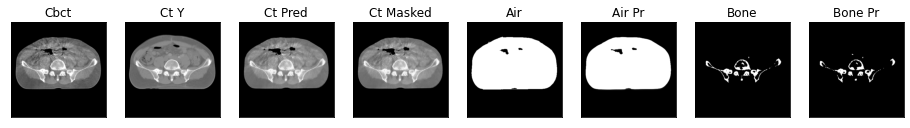

41it [00:51,  1.24s/it]

ssim score = 0.8634113073348999
psnr score = 24.737361907958984
snr score = 15.118274688720703
mae error = 0.023176318034529686
air dice score = 0.9962079853631214
bone dice score = 0.9083605322644147
contour dice score = 0.4628821015357971


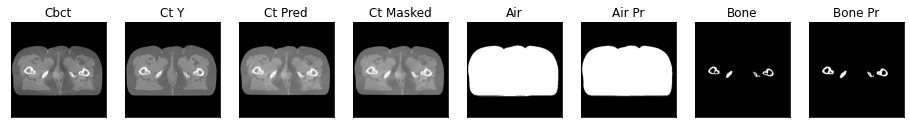

ssim score = 0.8644107580184937
psnr score = 24.987957000732422
snr score = 15.48988151550293
mae error = 0.02202201634645462
air dice score = 0.9964237556428472
bone dice score = 0.9148116438374398
contour dice score = 0.4512617588043213


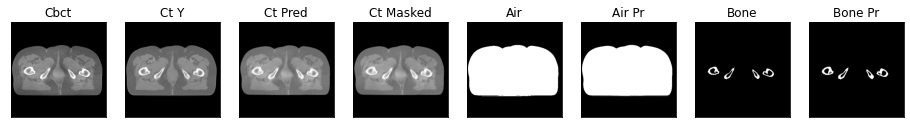

ssim score = 0.8604782819747925
psnr score = 25.009119033813477
snr score = 15.593961715698242
mae error = 0.021688612177968025
air dice score = 0.9964088780111183
bone dice score = 0.9194239003518991
contour dice score = 0.40644845366477966


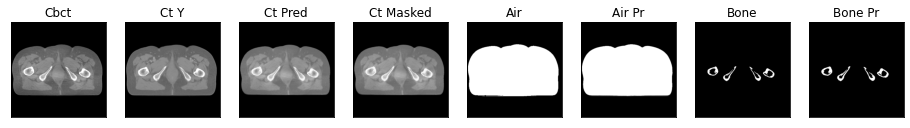

ssim score = 0.8577182292938232
psnr score = 24.98345375061035
snr score = 15.63174057006836
mae error = 0.02179829217493534
air dice score = 0.9963827211505728
bone dice score = 0.9256744995661327
contour dice score = 0.4230581223964691


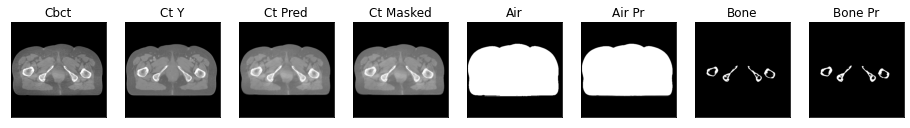

42it [00:52,  1.22s/it]

ssim score = 0.857805609703064
psnr score = 24.886009216308594
snr score = 15.56275749206543
mae error = 0.021969368681311607
air dice score = 0.9963085769600327
bone dice score = 0.9397468354440549
contour dice score = 0.39881831407546997


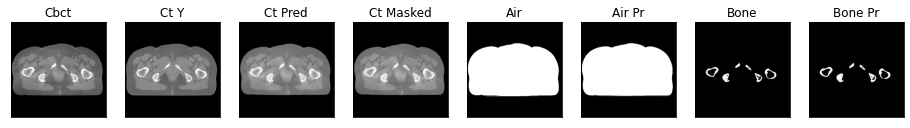

ssim score = 0.8597592711448669
psnr score = 24.815139770507812
snr score = 15.51484203338623
mae error = 0.021799681708216667
air dice score = 0.9963680910859722
bone dice score = 0.9342681858030804
contour dice score = 0.3848027288913727


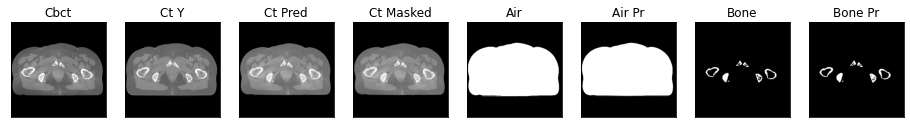

ssim score = 0.8564901351928711
psnr score = 24.72196388244629
snr score = 15.452993392944336
mae error = 0.02197118289768696
air dice score = 0.9961820260427554
bone dice score = 0.9321595028494363
contour dice score = 0.37427467107772827


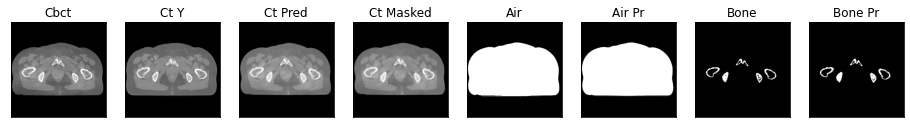

ssim score = 0.8543465733528137
psnr score = 24.302167892456055
snr score = 15.081560134887695
mae error = 0.022683359682559967
air dice score = 0.9955882564272094
bone dice score = 0.9400890106138293
contour dice score = 0.3623529374599457


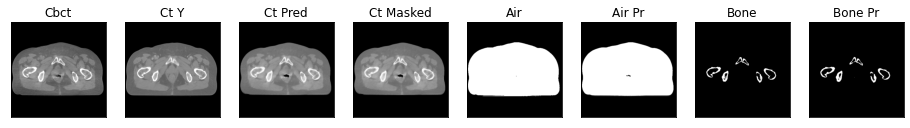

43it [00:53,  1.26s/it]

ssim score = 0.8547676801681519
psnr score = 24.144390106201172
snr score = 14.966527938842773
mae error = 0.022611746564507484
air dice score = 0.9956075713679823
bone dice score = 0.9408514787139933
contour dice score = 0.3519230782985687


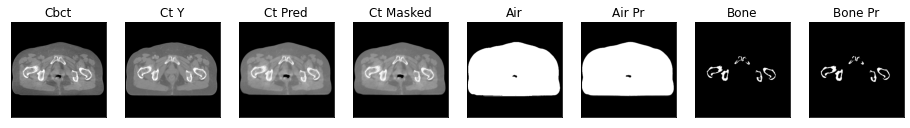

ssim score = 0.8527950048446655
psnr score = 24.01502227783203
snr score = 14.924861907958984
mae error = 0.022833961993455887
air dice score = 0.9956367661752369
bone dice score = 0.93944636678288
contour dice score = 0.31588783860206604


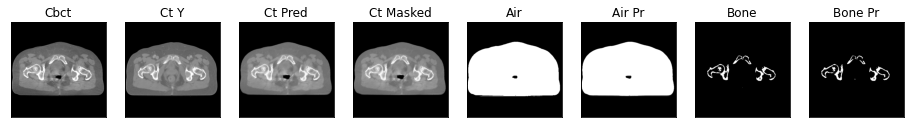

ssim score = 0.8548234701156616
psnr score = 24.74860954284668
snr score = 15.771722793579102
mae error = 0.02192053198814392
air dice score = 0.9954718114900133
bone dice score = 0.9241566116729357
contour dice score = 0.3434903025627136


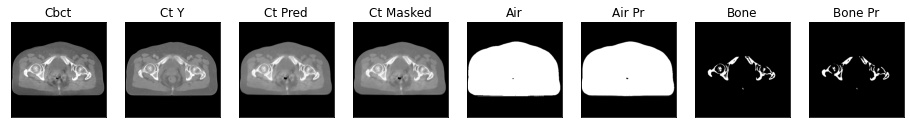

ssim score = 0.8559719324111938
psnr score = 24.169424057006836
snr score = 15.063986778259277
mae error = 0.022218622267246246
air dice score = 0.995225532647037
bone dice score = 0.9222093216134979
contour dice score = 0.34135061502456665


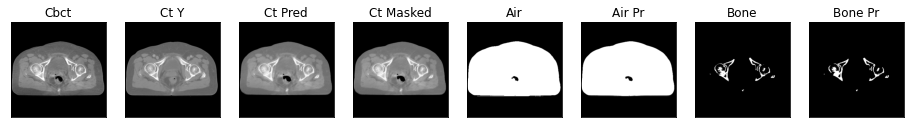

44it [00:54,  1.24s/it]

ssim score = 0.85722815990448
psnr score = 24.257808685302734
snr score = 15.042945861816406
mae error = 0.02203909307718277
air dice score = 0.995723955162414
bone dice score = 0.9064826584364176
contour dice score = 0.33208605647087097


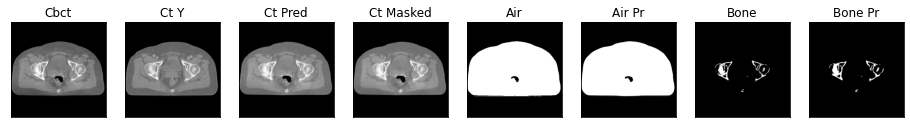

ssim score = 0.8586438298225403
psnr score = 24.274524688720703
snr score = 15.032538414001465
mae error = 0.022435354068875313
air dice score = 0.9959590478774321
bone dice score = 0.9259136212636891
contour dice score = 0.3544536232948303


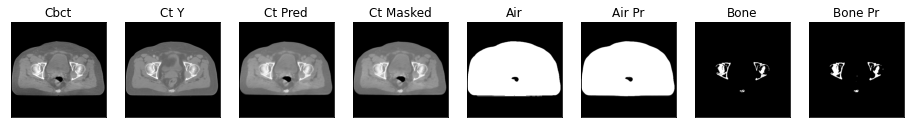

ssim score = 0.8633901476860046
psnr score = 24.849777221679688
snr score = 15.599783897399902
mae error = 0.022089464589953423
air dice score = 0.9962279106305006
bone dice score = 0.9380417335483461
contour dice score = 0.3514018654823303


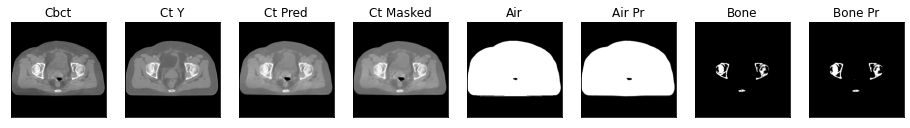

ssim score = 0.8633390665054321
psnr score = 25.545272827148438
snr score = 16.32950782775879
mae error = 0.020912982523441315
air dice score = 0.9965496928385112
bone dice score = 0.9500462534697803
contour dice score = 0.3800094425678253


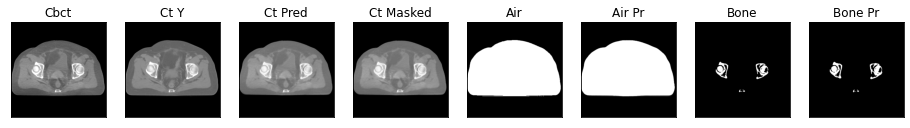

45it [00:56,  1.21s/it]

ssim score = 0.8600443601608276
psnr score = 25.048358917236328
snr score = 15.884085655212402
mae error = 0.022153496742248535
air dice score = 0.9971114962449471
bone dice score = 0.9591900311532836
contour dice score = 0.37686747312545776


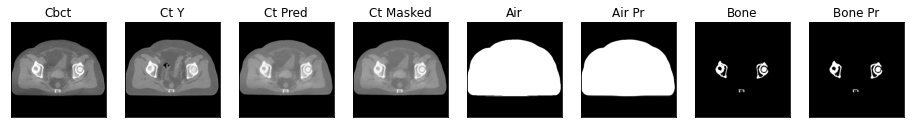

ssim score = 0.8474799394607544
psnr score = 24.26641082763672
snr score = 15.13969612121582
mae error = 0.024212419986724854
air dice score = 0.9972869421145302
bone dice score = 0.9515212303585503
contour dice score = 0.3889695107936859


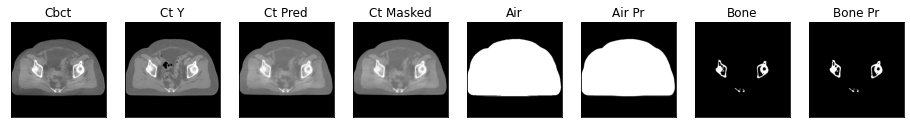

ssim score = 0.8292921185493469
psnr score = 22.587425231933594
snr score = 13.388276100158691
mae error = 0.028619511052966118
air dice score = 0.9963173523340605
bone dice score = 0.9203245267335068
contour dice score = 0.3317025303840637


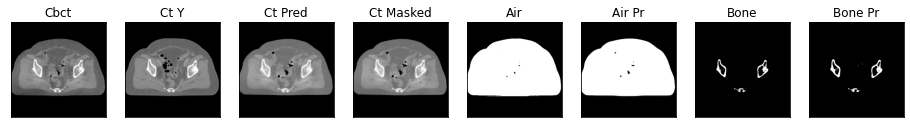

ssim score = 0.8174449801445007
psnr score = 22.216201782226562
snr score = 12.999056816101074
mae error = 0.030416902154684067
air dice score = 0.9959538479383757
bone dice score = 0.9360354654858342
contour dice score = 0.31568530201911926


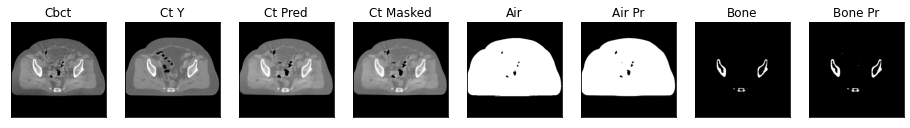

46it [00:57,  1.27s/it]

ssim score = 0.815153956413269
psnr score = 22.695842742919922
snr score = 13.54361343383789
mae error = 0.029616842046380043
air dice score = 0.9958001350438921
bone dice score = 0.9336040609150538
contour dice score = 0.31370609998703003


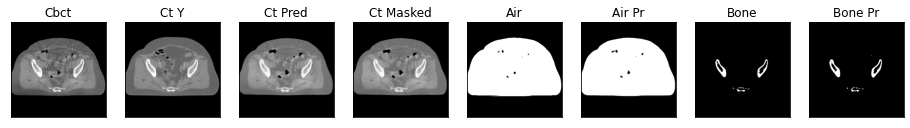

ssim score = 0.8182284235954285
psnr score = 23.029634475708008
snr score = 13.932499885559082
mae error = 0.02861667051911354
air dice score = 0.9955832753359417
bone dice score = 0.9417970810630948
contour dice score = 0.3062344193458557


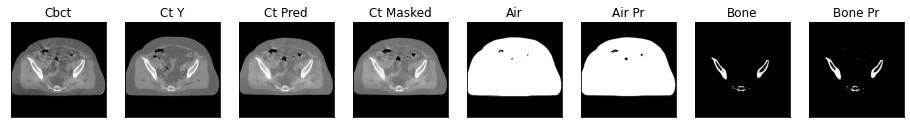

ssim score = 0.8134756088256836
psnr score = 22.473085403442383
snr score = 13.44037914276123
mae error = 0.029878374189138412
air dice score = 0.9957388716956403
bone dice score = 0.9468037550298495
contour dice score = 0.28754308819770813


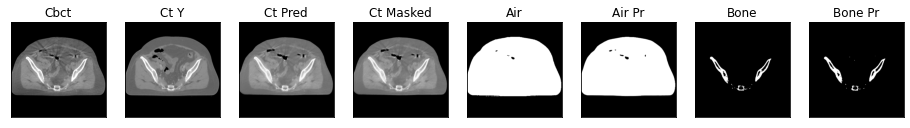

ssim score = 0.8117582201957703
psnr score = 22.266307830810547
snr score = 13.306459426879883
mae error = 0.03031059540808201
air dice score = 0.9954362522029648
bone dice score = 0.9369742104545997
contour dice score = 0.25283950567245483


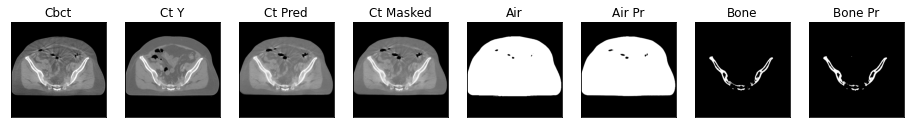

47it [00:58,  1.24s/it]

ssim score = 0.8119747042655945
psnr score = 22.13728141784668
snr score = 13.17314624786377
mae error = 0.030873583629727364
air dice score = 0.9948445534991811
bone dice score = 0.9254945980086222
contour dice score = 0.2521994113922119


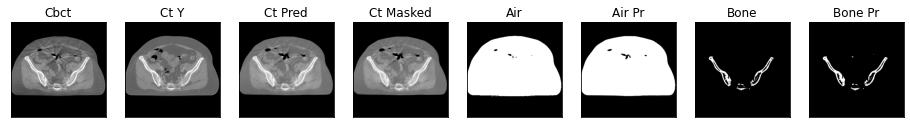

ssim score = 0.8122984766960144
psnr score = 22.270221710205078
snr score = 13.28390884399414
mae error = 0.03065439499914646
air dice score = 0.9957044396070075
bone dice score = 0.9260606060616019
contour dice score = 0.2625182271003723


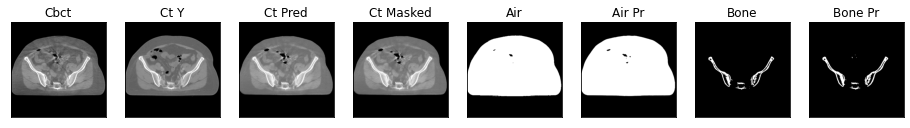

ssim score = 0.8194217681884766
psnr score = 23.076683044433594
snr score = 14.10200309753418
mae error = 0.02878928929567337
air dice score = 0.9961797134465152
bone dice score = 0.9276417074887664
contour dice score = 0.27619507908821106


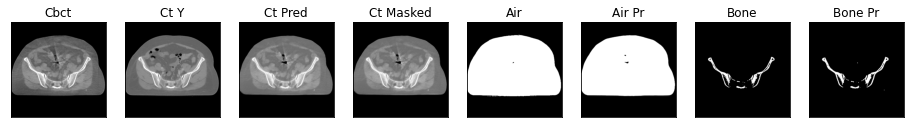

48it [00:59,  1.24s/it]


In [38]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [39]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [40]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [41]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

48it [00:06,  6.95it/s]


(0.840916246175766,
 23.18476414680481,
 14.19237470626831,
 0.02843318204395473,
 0.995863734019664,
 0.9127562281151085,
 0.4472395180095553,
 0.4739583333333333)

In [42]:
# import torchvision.models as models
# models.vgg16(pretrained=True)